# Coating studies

Studies of coating for HL-LHC and RunIII

In [1]:
%pylab notebook
from Impedance import *
from string import *
import itertools
import os
from  scipy.constants import c as clight
import skrf as rf

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times New Roman'],'size':12})
rc('text', usetex=True)

Populating the interactive namespace from numpy and matplotlib




# Various sandwich cases

## CFC bulk

<IPython.core.display.Javascript object>


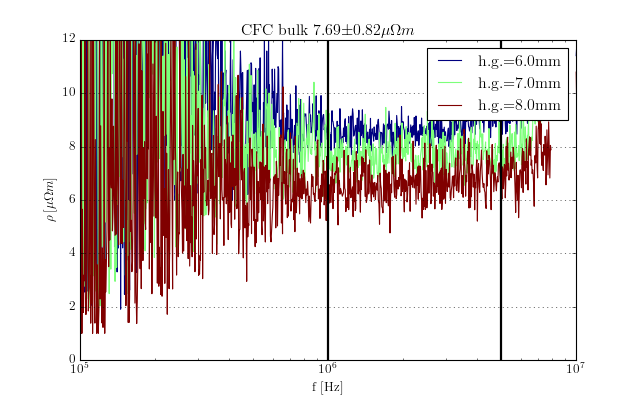

In [3]:
# plt.clf()
close('all')
IWDir='/afs/cern.ch/user/n/nbiancac/ln_delphi/ImpedanceWake2D/';
block_scenario='CFC_bulk/'
ref_scenario='Al_samples/'

hgap_vec=np.array([6.0,7.0,8.0])*1e-3
rhoDC_vec=np.arange(1,12.5,.5)*1e-6
thick_coat=27e-3
thick_ref=10e-3
L_sim=1
L_active=123e-3; # length of the blocks

# plots
cols=[plt.cm.jet(ii) for ii in (np.linspace(0,1,len(hgap_vec)))]
flagsave=1

# LXPLUS
lxbatchImp='retrieve'
queue='1nh'

# for conductivity determination
flim=[1e6,5e6]; 

#loop
N=2; # num of windings in coil
Delta=6.3e-3; # full distance coil windings

MeasDir='/afs/cern.ch/work/n/nbiancac/scratch0/RF/CFC_bulk/17-03-2016/thick_probe_N2/'
ResultDir=MeasDir+'Results/'; 
if not os.path.exists(ResultDir): 
    os.mkdir(ResultDir)
    
h_vec=[];leg_vec=[];rho_mean_vec=[];
fig_=figure(figsize=(8,5))
for hgap in hgap_vec:
    
    imp_mod={}
    imp_mod['sim']={};imp_mod['meas']={}
    imp_mod['sim']['mat']=[]
    imp_mod['sim']['freq']=[]
    imp_mod['meas']['value']=[]
    imp_mod['meas']['freq']=[]
    
    # IW2D simulations for reference block
    freq=freq_param(fmin=1e4,fmax=1e7,ftypescan=2,nflog=20,fadded=[],fmaxrefine=1e7,fminrefine=1.1e7,nrefine=1)
        
    Alu_lay=Alu_layer(thickness=thick_ref)
    vac_lay=vacuum_layer(thickness=np.inf)
    jaw=construct_layers([Alu_lay,vac_lay])
    comment='_HG'+str(hgap*1e3)+'mm'

    dire=ref_scenario+'/'+str(hgap*1e3)+'/';
    iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
    iw_ref,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
    multiply_impedance_wake(iw_ref,L_active/L_sim)
    
    # IW2D simulations for coated block
    for rhoDC in rhoDC_vec:

        Z_lay=Z_layer(rhoDC=rhoDC, thickness=thick_coat)
        vac_lay=vacuum_layer(thickness=np.inf)
        jaw=construct_layers([Z_lay,vac_lay])
        comment='_HG'+str(hgap*1e3)+'mm_coat-'+str(thick_coat*1e6)+'um-'+str(rhoDC*1e9)+'nOhmm'
        
        dire=block_scenario+'/'+str(hgap*1e3)+'/';
        iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
        iw_block,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
        multiply_impedance_wake(iw_block,L_active/L_sim)
        if lxbatchImp!='launch':
            a,b,c,d,plane,wakeflag=identify_component('Zydip')
            for iw in iw_block:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_block=iw.func[:,0]+1j*iw.func[:,1]
            for iw in iw_ref:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_ref=iw.func[:,0]+1j*iw.func[:,1]
            imp_mod['sim']['mat'].append(Z_block-Z_ref)

    imp_mod['sim']['freq']=freqscan_from_fpar(freq)

    # Measurements
    Block=rf.network.Network((MeasDir+'%dmm/block/TS0.S4P'%(hgap*1e3)))
    Ref=rf.network.Network((MeasDir+'%dmm/ref/TS0.S4P'%(hgap*1e3)))

    imp_mod['meas']['value']=clight/(Block.s11.f*2*pi)*(np.squeeze(Block.s11.z)-np.squeeze(Ref.s11.z))/(N**2)/(Delta**2)
    imp_mod['meas']['freq']=Block.s11.f

    newmat=[];
    for kk in np.arange(0,np.size(imp_mod['sim']['mat'],0)):
        col=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.real(imp_mod['sim']['mat'][kk]))
        newmat.append(col)

    newmat=np.array(newmat)  
    imp_mod['sim']['freq_int']=imp_mod['meas']['freq']
    imp_mod['sim']['mat_int']=newmat


    if lxbatchImp=='retrieve':
        rho_int=[];
        for kk in np.arange(0,np.size(imp_mod['sim']['mat_int'],1)):
            rho_int.append(np.interp(np.real(imp_mod['meas']['value'][kk]),imp_mod['sim']['mat_int'][:,kk],rhoDC_vec))


        
        h,=semilogx(imp_mod['sim']['freq_int'],np.array(rho_int)*1e6, label='h.g.=%.1fmm'%(hgap*1e3),c=cols[np.squeeze(np.where(hgap_vec==hgap))])
        h_vec.append(h)
        leg_vec.append('h.g.=%.1fmm'%(hgap*1e3))

        rho_vec=np.array(rho_int)
        rho_vec=rho_vec[(imp_mod['sim']['freq_int']>flim[0]) & (imp_mod['sim']['freq_int']<flim[1])]
        rho_mean_vec.append(mean(rho_vec))

rho_mean=mean(rho_mean_vec)
rho_std=std(rho_mean_vec)
axvline(x=flim[0], linewidth=2,color='k')
axvline(x=flim[1], linewidth=2,color='k')
ylim(0, np.max(rhoDC_vec*1e6))
xlim(1e5,1e7)
xlabel(r'\text{f [Hz]}')
ylabel(r'\rho\, [\mu \Omega m]')
legend(tuple(h_vec),tuple(leg_vec))
grid()
title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f\pm%.2f'%(rho_mean*1e6,rho_std*1e6)+'\mu \Omega m')

if flagsave:
    savefig(ResultDir+'rho_vs_f.pdf')
    savefig(ResultDir+'rho_vs_f.png')

<IPython.core.display.Javascript object>


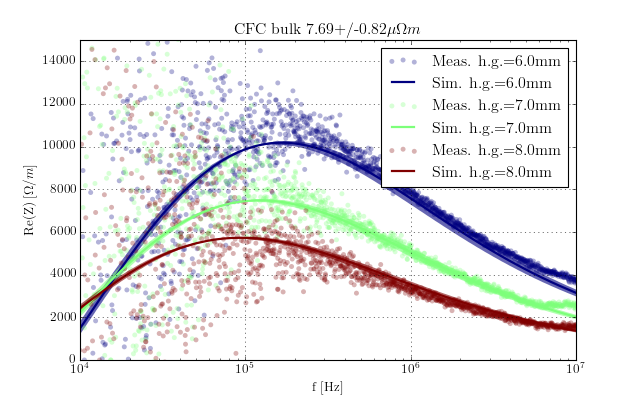

<IPython.core.display.Javascript object>


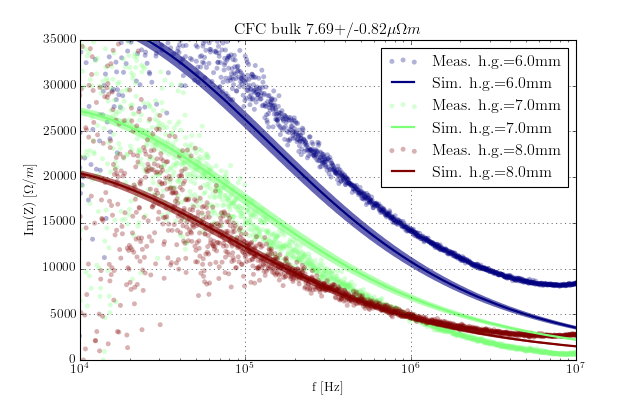

In [4]:
#plot reconstructed
close('all')
rhoDC_vec=np.array([rho_mean,rho_mean+rho_std,rho_mean-rho_std])
lxbatchImp='retrieve'    
h_vec=[];leg_vec=[]; data=[]
cols=[plt.cm.jet(ii) for ii in (np.linspace(0,1,len(hgap_vec)))]
for hgap in hgap_vec:
    
    
    imp_mod={}
    imp_mod['sim']={};imp_mod['meas']={}
    imp_mod['sim']['mat']=[]
    imp_mod['sim']['freq']=[]
    imp_mod['meas']['value']=[]
    imp_mod['meas']['freq']=[]
    
    # IW2D simulations for reference block
    freq=freq_param(fmin=1e4,fmax=1e7,ftypescan=2,nflog=20,fadded=[],fmaxrefine=1e7,fminrefine=1.1e7,nrefine=1)
        
    Alu_lay=Alu_layer(thickness=thick_ref)
    vac_lay=vacuum_layer(thickness=np.inf)
    jaw=construct_layers([Alu_lay,vac_lay])
    comment='_HG'+str(hgap*1e3)+'mm'

    dire=ref_scenario+'/'+str(hgap*1e3)+'/';
    iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
    iw_ref,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
    multiply_impedance_wake(iw_ref,L_active/L_sim)
    
    # IW2D simulations for coated block
    for rhoDC in rhoDC_vec:

        Z_lay=Z_layer(rhoDC=rhoDC, thickness=thick_coat)
        vac_lay=vacuum_layer(thickness=np.inf)
        jaw=construct_layers([Z_lay,vac_lay])
        comment='_HG'+str(hgap*1e3)+'mm_coat-'+str(thick_coat*1e6)+'um-'+str(rhoDC*1e9)+'nOhmm'
        
        dire=block_scenario+'/'+str(hgap*1e3)+'/';
        iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
        iw_block,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
        multiply_impedance_wake(iw_block,L_active/L_sim)
        if lxbatchImp!='launch':
            a,b,c,d,plane,wakeflag=identify_component('Zydip')
            for iw in iw_block:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_block=iw.func[:,0]+1j*iw.func[:,1]
            for iw in iw_ref:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_ref=iw.func[:,0]+1j*iw.func[:,1]
            imp_mod['sim']['mat'].append(Z_block-Z_ref)
    
    imp_mod['sim']['freq']=freqscan_from_fpar(freq)

    # Measurements
    Block=rf.network.Network((MeasDir+'%dmm/block/TS0.S4P'%(hgap*1e3)))
    Ref=rf.network.Network((MeasDir+'%dmm/ref/TS0.S4P'%(hgap*1e3)))

    imp_mod['meas']['value']=clight/(Block.s11.f*2*pi)*(np.squeeze(Block.s11.z)-np.squeeze(Ref.s11.z))/(N**2)/(Delta**2)
    imp_mod['meas']['freq']=Block.s11.f

    newmat=[];
    for kk in np.arange(0,np.size(imp_mod['sim']['mat'],0)):
        col_re=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.real(imp_mod['sim']['mat'][kk]))
        col_im=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.imag(imp_mod['sim']['mat'][kk]))
        col=col_re+1j*col_im;
        newmat.append(col)

    newmat=np.array(newmat)  
    imp_mod['sim']['freq_int']=imp_mod['meas']['freq']
    imp_mod['sim']['mat_int']=newmat
    
    if lxbatchImp=='retrieve':
        figure(4,figsize=(8,5))
        x=imp_mod['sim']['freq_int']
        scatter(imp_mod['meas']['freq'],np.real(imp_mod['meas']['value']),alpha=0.3,edgecolor='none',               
                   color=cols[np.squeeze(np.where(hgap_vec==hgap))],label='Sim. h.g.=%.1fmm'%(hgap*1e3))
        plot(x,np.real(imp_mod['sim']['mat_int'][0,:]),c=cols[np.squeeze(np.where(hgap_vec==hgap))],
                linewidth=2,label='Meas. h.g.=%.1fmm'%(hgap*1e3))
        fill_between(x, np.real(imp_mod['sim']['mat_int'][1,:]), np.real(imp_mod['sim']['mat_int'][2,:]),
                     facecolor=cols[np.squeeze(np.where(hgap_vec==hgap))], alpha=0.6, edgecolor='none')
        xscale('log')
        xlim(10**4,10**7)
        ylim(0,15e3)
        title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f+/-%.2f'%(rho_mean*1e6,rho_std*1e6)+'\mu\Omega m')
        xlabel('f [Hz]')
        ylabel('Re(Z) [\Omega/m]')

        figure(5,figsize=(8,5))
        x=imp_mod['sim']['freq_int']
        h=scatter(imp_mod['meas']['freq'],np.imag(imp_mod['meas']['value']),alpha=0.3,edgecolor='none',               
                   color=cols[np.squeeze(np.where(hgap_vec==hgap))],label='Meas. h.g.=%.1fmm'%(hgap*1e3))
        h_vec.append(h)
        leg_vec.append('Meas. h.g.=%.1fmm'%(hgap*1e3))
        h,=plot(x,np.imag(imp_mod['sim']['mat_int'][0,:]),c=cols[np.squeeze(np.where(hgap_vec==hgap))],
                linewidth=2,label='Sim. h.g.=%.1fmm'%(hgap*1e3))
        h_vec.append(h)
        leg_vec.append('Sim. h.g.=%.1fmm'%(hgap*1e3))
        fill_between(x, np.imag(imp_mod['sim']['mat_int'][1,:]), np.imag(imp_mod['sim']['mat_int'][2,:]),
                     facecolor=cols[np.squeeze(np.where(hgap_vec==hgap))], alpha=0.6, edgecolor='none')
        xscale('log')
        xlim(10**4,10**7)
        ylim(0,35e3)
        title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f+/-%.2f'%(rho_mean*1e6,rho_std*1e6)+'\mu\Omega m')
        xlabel('f [Hz]')
        ylabel('Im(Z) [\Omega/m]')
    


figure(4)    
grid()
legend(h_vec,leg_vec)
if flagsave:
    savefig(ResultDir+'reZ_vs_f.pdf')
    savefig(ResultDir+'reZ_vs_f.png')
    
figure(5)    
grid()
legend(h_vec,leg_vec)
if flagsave:
    savefig(ResultDir+'imZ_vs_f.pdf')
    savefig(ResultDir+'imZ_vs_f.png')
    
        

## TiN coating on CFC

<IPython.core.display.Javascript object>


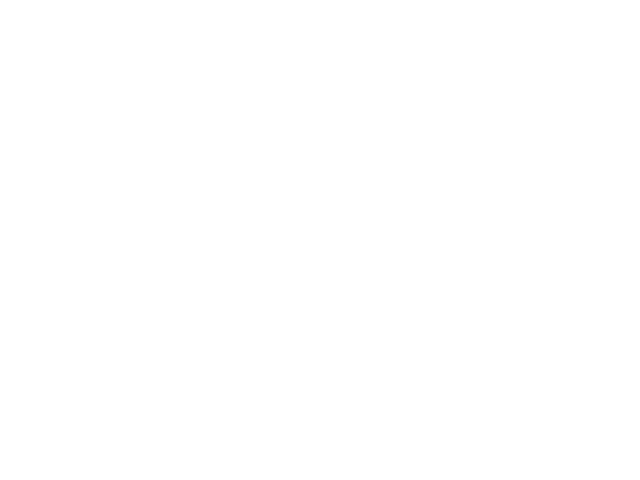

<IPython.core.display.Javascript object>


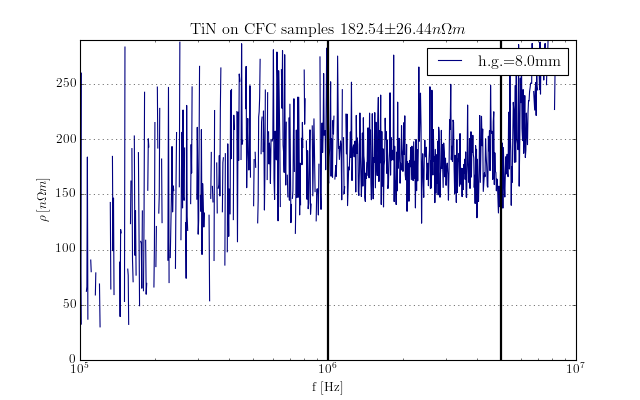

0.008


In [2]:
plt.clf()
plt.close('all')
IWDir='/afs/cern.ch/user/n/nbiancac/ln_delphi/ImpedanceWake2D/';
block_scenario='TiN_on_CFC_samples/';
ref_scenario='Al_samples/'
os.system('mkdir -p '+block_scenario)

hgap_vec=np.arange(8.0,9.0,1.0)*1e-3
rhoDC_vec=np.arange(10.0,300.0,10.)*1e-9
thick_coat=4.7e-6;
rhoDC_bulk=7.69e-6;
thick_bulk=27e-3;
thick_ref=10e-3;

L_sim=1
L_active=123e-3; # length of the blocks

# plots
cols=[plt.cm.jet(ii) for ii in (np.linspace(0,1,len(hgap_vec)))]
flagsave=1

# LXPLUS
lxbatchImp='retrieve'
queue='1nh'

# for conductivity determination
flim=[1e6,5e6]; 

#loop
N=2; # num of windings in coil
Delta=6.3e-3; # full distance coil windings

MeasDir='/afs/cern.ch/work/n/nbiancac/scratch0/RF/TiN_on_CFC_samples/17-03-2016/thick_probe_N2/'
ResultDir=MeasDir+'Results/'; 
if not os.path.exists(ResultDir): 
    os.mkdir(ResultDir)
    
h_vec=[];leg_vec=[];rho_mean_vec=[];

for hgap in hgap_vec:
    
    imp_mod={}
    imp_mod['sim']={};imp_mod['meas']={}
    imp_mod['sim']['mat']=[]
    imp_mod['sim']['freq']=[]
    imp_mod['meas']['value']=[]
    imp_mod['meas']['freq']=[]
    
    # IW2D simulations for reference block
    freq=freq_param(fmin=1e4,fmax=1e7,ftypescan=2,nflog=20,fadded=[],fmaxrefine=1e7,fminrefine=1.1e7,nrefine=1)
        
    Alu_lay=Alu_layer(thickness=thick_ref)
    vac_lay=vacuum_layer(thickness=np.inf)
    jaw=construct_layers([Alu_lay,vac_lay])
    comment='_HG'+str(hgap*1e3)+'mm'

    dire=ref_scenario+'/'+str(hgap*1e3)+'/';
    iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
    iw_ref,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
    multiply_impedance_wake(iw_ref,L_active/L_sim)
    
    # IW2D simulations for coated block
    for rhoDC in rhoDC_vec:

        Z_lay=Z_layer(rhoDC=rhoDC, thickness=thick_coat)
        bulk_lay=CFC_layer(thickness=thick_bulk)
        bulk_lay.rhoDC=rhoDC_bulk
        vac_lay=vacuum_layer(thickness=np.inf)
        jaw=construct_layers([Z_lay,bulk_lay,vac_lay])
        comment='_HG'+str(hgap*1e3)+'mm_coat-'+str(thick_coat*1e6)+'um-'+str(rhoDC*1e9)+'nOhmm'
        
        dire=block_scenario+'/'+str(hgap*1e3)+'/';
        iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
        iw_block,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
        multiply_impedance_wake(iw_block,L_active/L_sim)
        if lxbatchImp!='launch':
            a,b,c,d,plane,wakeflag=identify_component('Zydip')
            for iw in iw_block:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_block=iw.func[:,0]+1j*iw.func[:,1]
            for iw in iw_ref:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_ref=iw.func[:,0]+1j*iw.func[:,1]
            imp_mod['sim']['mat'].append(Z_block-Z_ref)

    imp_mod['sim']['freq']=freqscan_from_fpar(freq)

    # Measurements
    Block=rf.network.Network((MeasDir+'%dmm/block/TS0.S4P'%(hgap*1e3)))
    Ref=rf.network.Network((MeasDir+'%dmm/ref/TS0.S4P'%(hgap*1e3)))

    imp_mod['meas']['value']=clight/(Block.s11.f*2*pi)*(np.squeeze(Block.s11.z)-np.squeeze(Ref.s11.z))/(N**2)/(Delta**2)
    imp_mod['meas']['freq']=Block.s11.f

    newmat=[];
    for kk in np.arange(0,np.size(imp_mod['sim']['mat'],0)):
        col_re=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.real(imp_mod['sim']['mat'][kk]))
        col_im=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.imag(imp_mod['sim']['mat'][kk]))
        col=col_re+1j*col_im
        newmat.append(col)

    newmat=np.array(newmat)  
    imp_mod['sim']['freq_int']=imp_mod['meas']['freq']
    imp_mod['sim']['mat_int']=newmat


    if lxbatchImp=='retrieve':
        rho_int=[];
        for kk in np.arange(0,np.size(imp_mod['sim']['mat_int'],1)):
            rho_int.append(np.interp(np.imag(imp_mod['meas']['value'][kk]),np.imag(imp_mod['sim']['mat_int'][:,kk]),rhoDC_vec))

        rho_vec=np.array(rho_int)
        rho_vec[rho_vec==max(rhoDC_vec)]=nan
        
        figure(num=1,figsize=(8,5))
        h,=plot(imp_mod['sim']['freq_int'],(rho_vec)*1e9, label='h.g.=%.1fmm'%(hgap*1e3),
               c=cols[np.squeeze(np.where(hgap_vec==hgap))])
        xscale('log')
        h_vec.append(h)
        leg_vec.append('h.g.=%.1fmm'%(hgap*1e3))
        print hgap

        
        rho_vec=rho_vec[(imp_mod['sim']['freq_int']>flim[0]) & (imp_mod['sim']['freq_int']<flim[1])]
        rho_mean_vec.append(np.nanmean(rho_vec))

if lxbatchImp=='retrieve':        
    rho_mean=mean(rho_mean_vec)
    if len(hgap_vec)>1:
        rho_std=std(rho_vec)
    else:
        rho_std=np.nanstd(rho_vec)
    axvline(x=flim[0], linewidth=2,color='k')
    axvline(x=flim[1], linewidth=2,color='k')
    ylim(0, np.max(rhoDC_vec*1e9))
    xlim(1e5,1e7)
    xlabel(r'\text{f [Hz]}')
    ylabel(r'\rho\, [n \Omega m]')
    legend(tuple(h_vec),tuple(leg_vec))
    grid()
    title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f\pm%.2f'%(rho_mean*1e9,rho_std*1e9)+'n \Omega m')

    if flagsave:
        savefig(ResultDir+'rho_vs_f.pdf')
        savefig(ResultDir+'rho_vs_f.png')

<IPython.core.display.Javascript object>


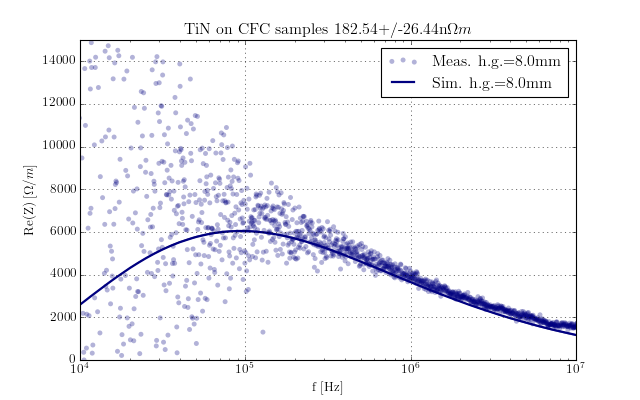

<IPython.core.display.Javascript object>


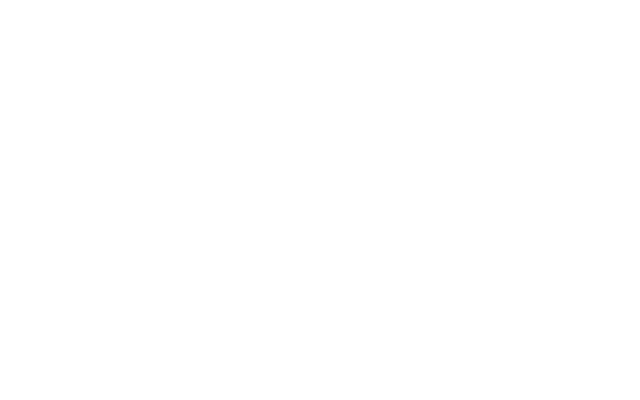

In [3]:
#plot reconstructed
close('all')
rhoDC_vec=np.array([rho_mean,rho_mean+rho_std,rho_mean-rho_std])
lxbatchImp='retrieve'    
h_vec=[];leg_vec=[]; data=[]
cols=[plt.cm.jet(ii) for ii in (np.linspace(0,1,len(hgap_vec)))]
for hgap in hgap_vec:
    
    
    imp_mod={}
    imp_mod['sim']={};imp_mod['meas']={}
    imp_mod['sim']['mat']=[]
    imp_mod['sim']['freq']=[]
    imp_mod['meas']['value']=[]
    imp_mod['meas']['freq']=[]
    
    # IW2D simulations for reference block
    freq=freq_param(fmin=1e4,fmax=1e7,ftypescan=2,nflog=20,fadded=[],fmaxrefine=1e7,fminrefine=1.1e7,nrefine=1)
        
    Alu_lay=Alu_layer(thickness=thick_ref)
    vac_lay=vacuum_layer(thickness=np.inf)
    jaw=construct_layers([Alu_lay,vac_lay])
    comment='_HG'+str(hgap*1e3)+'mm'

    dire=ref_scenario+'/'+str(hgap*1e3)+'/';
    iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
    iw_ref,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
    multiply_impedance_wake(iw_ref,L_active/L_sim)
    
    # IW2D simulations for coated block
    for rhoDC in rhoDC_vec:

        Z_lay=Z_layer(rhoDC=rhoDC, thickness=thick_coat)
        bulk_lay=CFC_layer(thickness=thick_bulk)
        bulk_lay.rhoDC=rhoDC_bulk
        vac_lay=vacuum_layer(thickness=np.inf)
        jaw=construct_layers([Z_lay,bulk_lay,vac_lay])
        comment='_HG'+str(hgap*1e3)+'mm_coat-'+str(thick_coat*1e6)+'um-'+str(rhoDC*1e9)+'nOhmm'
        
        dire=block_scenario+'/'+str(hgap*1e3)+'/';
        iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
        iw_block,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
        multiply_impedance_wake(iw_block,L_active/L_sim)
        if lxbatchImp!='launch':
            a,b,c,d,plane,wakeflag=identify_component('Zydip')
            for iw in iw_block:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_block=iw.func[:,0]+1j*iw.func[:,1]
            for iw in iw_ref:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_ref=iw.func[:,0]+1j*iw.func[:,1]
            imp_mod['sim']['mat'].append(Z_block-Z_ref)
    
    imp_mod['sim']['freq']=freqscan_from_fpar(freq)

    # Measurements
    Block=rf.network.Network((MeasDir+'%dmm/block/TS0.S4P'%(hgap*1e3)))
    Ref=rf.network.Network((MeasDir+'%dmm/ref/TS0.S4P'%(hgap*1e3)))

    imp_mod['meas']['value']=clight/(Block.s11.f*2*pi)*(np.squeeze(Block.s11.z)-np.squeeze(Ref.s11.z))/(N**2)/(Delta**2)
    imp_mod['meas']['freq']=Block.s11.f

    newmat=[];
    for kk in np.arange(0,np.size(imp_mod['sim']['mat'],0)):
        col_re=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.real(imp_mod['sim']['mat'][kk]))
        col_im=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.imag(imp_mod['sim']['mat'][kk]))
        col=col_re+1j*col_im;
        newmat.append(col)

    newmat=np.array(newmat)  
    imp_mod['sim']['freq_int']=imp_mod['meas']['freq']
    imp_mod['sim']['mat_int']=newmat
    
    if lxbatchImp=='retrieve':
        figure(4,figsize=(8,5))
        x=imp_mod['sim']['freq_int']
        scatter(imp_mod['meas']['freq'],np.real(imp_mod['meas']['value']),alpha=0.3,edgecolor='none',               
                   color=cols[np.squeeze(np.where(hgap_vec==hgap))],label='Sim. h.g.=%.1fmm'%(hgap*1e3))
        plot(x,np.real(imp_mod['sim']['mat_int'][0,:]),c=cols[np.squeeze(np.where(hgap_vec==hgap))],
                linewidth=2,label='Meas. h.g.=%.1fmm'%(hgap*1e3))
        fill_between(x, np.real(imp_mod['sim']['mat_int'][1,:]), np.real(imp_mod['sim']['mat_int'][2,:]),
                     facecolor=cols[np.squeeze(np.where(hgap_vec==hgap))], alpha=0.6, edgecolor='none')
        xscale('log')
        xlim(10**4,10**7)
        ylim(0,15e3)
        title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f+/-%.2f'%(rho_mean*1e9,rho_std*1e9)+'n\Omega m')
        xlabel('f [Hz]')
        ylabel('Re(Z) [\Omega/m]')

        figure(5,figsize=(8,5))
        x=imp_mod['sim']['freq_int']
        h=scatter(imp_mod['meas']['freq'],np.imag(imp_mod['meas']['value']),alpha=0.3,edgecolor='none',               
                   color=cols[np.squeeze(np.where(hgap_vec==hgap))],label='Meas. h.g.=%.1fmm'%(hgap*1e3))
        h_vec.append(h)
        leg_vec.append('Meas. h.g.=%.1fmm'%(hgap*1e3))
        h,=plot(x,np.imag(imp_mod['sim']['mat_int'][0,:]),c=cols[np.squeeze(np.where(hgap_vec==hgap))],
                linewidth=2,label='Sim. h.g.=%.1fmm'%(hgap*1e3))
        h_vec.append(h)
        leg_vec.append('Sim. h.g.=%.1fmm'%(hgap*1e3))
        fill_between(x, np.imag(imp_mod['sim']['mat_int'][1,:]), np.imag(imp_mod['sim']['mat_int'][2,:]),
                     facecolor=cols[np.squeeze(np.where(hgap_vec==hgap))], alpha=0.6, edgecolor='none')
        xscale('log')
        xlim(10**4,10**7)
        ylim(0,35e3)
        title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f+/-%.2f'%(rho_mean*1e9,rho_std*1e9)+'n\Omega m')
        xlabel('f [Hz]')
        ylabel('Im(Z) [\Omega/m]')
    

if lxbatchImp=='retrieve':
    figure(4)    
    grid()
    legend(h_vec,leg_vec)
    if flagsave:
        savefig(ResultDir+'reZ_vs_f.pdf')
        savefig(ResultDir+'reZ_vs_f.png')

    figure(5)    
    grid()
    legend(h_vec,leg_vec)
    if flagsave:
        savefig(ResultDir+'imZ_vs_f.pdf')
        savefig(ResultDir+'imZ_vs_f.png')     

## C bulk

<IPython.core.display.Javascript object>


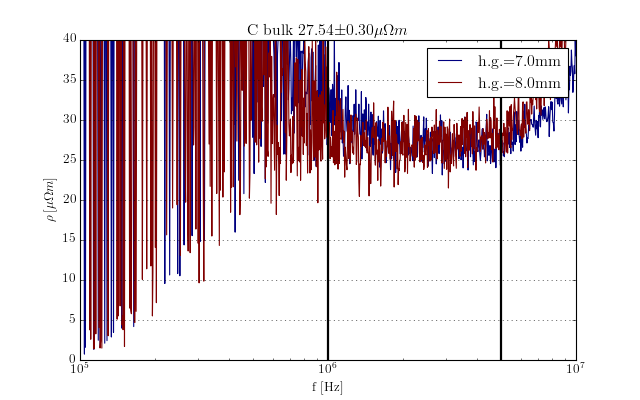

In [4]:
plt.clf()
IWDir='/afs/cern.ch/user/n/nbiancac/ln_delphi/ImpedanceWake2D/';
block_scenario='C_bulk/'
ref_scenario='Al_samples/'

hgap_vec=np.array([7.0,8.0])*1e-3
rhoDC_vec=np.arange(.5,40.5,.5)*1e-6
thick_coat=27e-3
thick_ref=10e-3
L_sim=1
L_active=123e-3; # length of the blocks

# plots
cols=[plt.cm.jet(ii) for ii in (np.linspace(0,1,len(hgap_vec)))]
flagsave=1

# LXPLUS
lxbatchImp='retrieve'
queue='1nh'

# for conductivity determination
flim=[1e6,5e6]; 

#loop
N=2; # num of windings in coil
Delta=6.3e-3; # full distance coil windings

MeasDir='/afs/cern.ch/work/n/nbiancac/scratch0/RF/C_bulk/17-03-2016/thick_probe_N2/'
ResultDir=MeasDir+'Results/'; 
if not os.path.exists(ResultDir): 
    os.mkdir(ResultDir)
    
h_vec=[];leg_vec=[];rho_mean_vec=[];
fig_=figure(figsize=(8,5))
for hgap in hgap_vec:
    
    imp_mod={}
    imp_mod['sim']={};imp_mod['meas']={}
    imp_mod['sim']['mat']=[]
    imp_mod['sim']['freq']=[]
    imp_mod['meas']['value']=[]
    imp_mod['meas']['freq']=[]
    
    # IW2D simulations for reference block
    freq=freq_param(fmin=1e4,fmax=1e7,ftypescan=2,nflog=20,fadded=[],fmaxrefine=1e7,fminrefine=1.1e7,nrefine=1)
        
    Alu_lay=Alu_layer(thickness=thick_ref)
    vac_lay=vacuum_layer(thickness=np.inf)
    jaw=construct_layers([Alu_lay,vac_lay])
    comment='_HG'+str(hgap*1e3)+'mm'

    dire=ref_scenario+'/'+str(hgap*1e3)+'/';
    iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
    iw_ref,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
    multiply_impedance_wake(iw_ref,L_active/L_sim)
    
    # IW2D simulations for coated block
    for rhoDC in rhoDC_vec:

        Z_lay=Z_layer(rhoDC=rhoDC, thickness=thick_coat)
        vac_lay=vacuum_layer(thickness=np.inf)
        jaw=construct_layers([Z_lay,vac_lay])
        comment='_HG'+str(hgap*1e3)+'mm_coat-'+str(thick_coat*1e6)+'um-'+str(rhoDC*1e9)+'nOhmm'
        
        dire=block_scenario+'/'+str(hgap*1e3)+'/';
        iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
        iw_block,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
        multiply_impedance_wake(iw_block,L_active/L_sim)
        if lxbatchImp!='launch':
            a,b,c,d,plane,wakeflag=identify_component('Zydip')
            for iw in iw_block:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_block=iw.func[:,0]+1j*iw.func[:,1]
            for iw in iw_ref:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_ref=iw.func[:,0]+1j*iw.func[:,1]
            imp_mod['sim']['mat'].append(Z_block-Z_ref)

    imp_mod['sim']['freq']=freqscan_from_fpar(freq)

    # Measurements
    Block=rf.network.Network((MeasDir+'%dmm/block/TS0.S4P'%(hgap*1e3)))
    Ref=rf.network.Network((MeasDir+'%dmm/ref/TS0.S4P'%(hgap*1e3)))

    imp_mod['meas']['value']=clight/(Block.s11.f*2*pi)*(np.squeeze(Block.s11.z)-np.squeeze(Ref.s11.z))/(N**2)/(Delta**2)
    imp_mod['meas']['freq']=Block.s11.f

    newmat=[];
    for kk in np.arange(0,np.size(imp_mod['sim']['mat'],0)):
        col=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.real(imp_mod['sim']['mat'][kk]))
        newmat.append(col)

    newmat=np.array(newmat)  
    imp_mod['sim']['freq_int']=imp_mod['meas']['freq']
    imp_mod['sim']['mat_int']=newmat


    if lxbatchImp=='retrieve':
        rho_int=[];
        for kk in np.arange(0,np.size(imp_mod['sim']['mat_int'],1)):
            rho_int.append(np.interp(np.real(imp_mod['meas']['value'][kk]),imp_mod['sim']['mat_int'][:,kk],rhoDC_vec))


        
        h,=semilogx(imp_mod['sim']['freq_int'],np.array(rho_int)*1e6, label='h.g.=%.1fmm'%(hgap*1e3),c=cols[np.squeeze(np.where(hgap_vec==hgap))])
        h_vec.append(h)
        leg_vec.append('h.g.=%.1fmm'%(hgap*1e3))

        rho_vec=np.array(rho_int)
        rho_vec=rho_vec[(imp_mod['sim']['freq_int']>flim[0]) & (imp_mod['sim']['freq_int']<flim[1])]
        rho_mean_vec.append(mean(rho_vec))

rho_mean=mean(rho_mean_vec)
rho_std=std(rho_mean_vec)
axvline(x=flim[0], linewidth=2,color='k')
axvline(x=flim[1], linewidth=2,color='k')
ylim(0, np.max(rhoDC_vec*1e6))
xlim(1e5,1e7)
xlabel(r'\text{f [Hz]}')
ylabel(r'\rho\, [\mu \Omega m]')
legend(tuple(h_vec),tuple(leg_vec))
grid()
title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f\pm%.2f'%(rho_mean*1e6,rho_std*1e6)+'\mu \Omega m')

if flagsave:
    savefig(ResultDir+'rho_vs_f.pdf')
    savefig(ResultDir+'rho_vs_f.png')

In [ ]:
#plot reconstructed
plt.clf()
rhoDC_vec=np.array([rho_mean,rho_mean+rho_std,rho_mean-rho_std])
lxbatchImp='retrieve'    
h_vec=[];leg_vec=[]; data=[]
cols=[plt.cm.jet(ii) for ii in (np.linspace(0,1,len(hgap_vec)))]
for hgap in hgap_vec:
    
    
    imp_mod={}
    imp_mod['sim']={};imp_mod['meas']={}
    imp_mod['sim']['mat']=[]
    imp_mod['sim']['freq']=[]
    imp_mod['meas']['value']=[]
    imp_mod['meas']['freq']=[]
    
    # IW2D simulations for reference block
    freq=freq_param(fmin=1e4,fmax=1e7,ftypescan=2,nflog=20,fadded=[],fmaxrefine=1e7,fminrefine=1.1e7,nrefine=1)
        
    Alu_lay=Alu_layer(thickness=thick_ref)
    vac_lay=vacuum_layer(thickness=np.inf)
    jaw=construct_layers([Alu_lay,vac_lay])
    comment='_HG'+str(hgap*1e3)+'mm'

    dire=ref_scenario+'/'+str(hgap*1e3)+'/';
    iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
    iw_ref,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
    multiply_impedance_wake(iw_ref,L_active/L_sim)
    
    # IW2D simulations for coated block
    for rhoDC in rhoDC_vec:

        Z_lay=Z_layer(rhoDC=rhoDC, thickness=thick_coat)
        vac_lay=vacuum_layer(thickness=np.inf)
        jaw=construct_layers([Z_lay,vac_lay])
        comment='_HG'+str(hgap*1e3)+'mm_coat-'+str(thick_coat*1e6)+'um-'+str(rhoDC*1e9)+'nOhmm'
        
        dire=block_scenario+'/'+str(hgap*1e3)+'/';
        iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
        iw_block,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
        multiply_impedance_wake(iw_block,L_active/L_sim)
        if lxbatchImp!='launch':
            a,b,c,d,plane,wakeflag=identify_component('Zydip')
            for iw in iw_block:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_block=iw.func[:,0]+1j*iw.func[:,1]
            for iw in iw_ref:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_ref=iw.func[:,0]+1j*iw.func[:,1]
            imp_mod['sim']['mat'].append(Z_block-Z_ref)
    
    imp_mod['sim']['freq']=freqscan_from_fpar(freq)

    # Measurements
    Block=rf.network.Network((MeasDir+'%dmm/block/TS0.S4P'%(hgap*1e3)))
    Ref=rf.network.Network((MeasDir+'%dmm/ref/TS0.S4P'%(hgap*1e3)))

    imp_mod['meas']['value']=clight/(Block.s11.f*2*pi)*(np.squeeze(Block.s11.z)-np.squeeze(Ref.s11.z))/(N**2)/(Delta**2)
    imp_mod['meas']['freq']=Block.s11.f

    newmat=[];
    for kk in np.arange(0,np.size(imp_mod['sim']['mat'],0)):
        col_re=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.real(imp_mod['sim']['mat'][kk]))
        col_im=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.imag(imp_mod['sim']['mat'][kk]))
        col=col_re+1j*col_im;
        newmat.append(col)

    newmat=np.array(newmat)  
    imp_mod['sim']['freq_int']=imp_mod['meas']['freq']
    imp_mod['sim']['mat_int']=newmat
    
    if lxbatchImp=='retrieve':
        figure(4,figsize=(8,5))
        x=imp_mod['sim']['freq_int']
        scatter(imp_mod['meas']['freq'],np.real(imp_mod['meas']['value']),alpha=0.3,edgecolor='none',               
                   color=cols[np.squeeze(np.where(hgap_vec==hgap))],label='Sim. h.g.=%.1fmm'%(hgap*1e3))
        plot(x,np.real(imp_mod['sim']['mat_int'][0,:]),c=cols[np.squeeze(np.where(hgap_vec==hgap))],
                linewidth=2,label='Meas. h.g.=%.1fmm'%(hgap*1e3))
        fill_between(x, np.real(imp_mod['sim']['mat_int'][1,:]), np.real(imp_mod['sim']['mat_int'][2,:]),
                     facecolor=cols[np.squeeze(np.where(hgap_vec==hgap))], alpha=0.6, edgecolor='none')
        xscale('log')
        xlim(10**4,10**7)
        ylim(0,15e3)
        title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f+/-%.2f'%(rho_mean*1e6,rho_std*1e6)+'\mu\Omega m')
        xlabel('f [Hz]')
        ylabel('Re(Z) [\Omega/m]')

        figure(5,figsize=(8,5))
        x=imp_mod['sim']['freq_int']
        h=scatter(imp_mod['meas']['freq'],np.imag(imp_mod['meas']['value']),alpha=0.3,edgecolor='none',               
                   color=cols[np.squeeze(np.where(hgap_vec==hgap))],label='Meas. h.g.=%.1fmm'%(hgap*1e3))
        h_vec.append(h)
        leg_vec.append('Meas. h.g.=%.1fmm'%(hgap*1e3))
        h,=plot(x,np.imag(imp_mod['sim']['mat_int'][0,:]),c=cols[np.squeeze(np.where(hgap_vec==hgap))],
                linewidth=2,label='Sim. h.g.=%.1fmm'%(hgap*1e3))
        h_vec.append(h)
        leg_vec.append('Sim. h.g.=%.1fmm'%(hgap*1e3))
        fill_between(x, np.imag(imp_mod['sim']['mat_int'][1,:]), np.imag(imp_mod['sim']['mat_int'][2,:]),
                     facecolor=cols[np.squeeze(np.where(hgap_vec==hgap))], alpha=0.6, edgecolor='none')
        xscale('log')
        xlim(10**4,10**7)
        ylim(0,35e3)
        title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f+/-%.2f'%(rho_mean*1e6,rho_std*1e6)+'\mu\Omega m')
        xlabel('f [Hz]')
        ylabel('Im(Z) [\Omega/m]')
    


figure(4)    
grid()
legend(h_vec,leg_vec)
if flagsave:
    savefig(ResultDir+'reZ_vs_f.pdf')
    savefig(ResultDir+'reZ_vs_f.png')
    
figure(5)    
grid()
legend(h_vec,leg_vec)
if flagsave:
    savefig(ResultDir+'imZ_vs_f.pdf')
    savefig(ResultDir+'imZ_vs_f.png')
    
        

## TiN on C

<IPython.core.display.Javascript object>


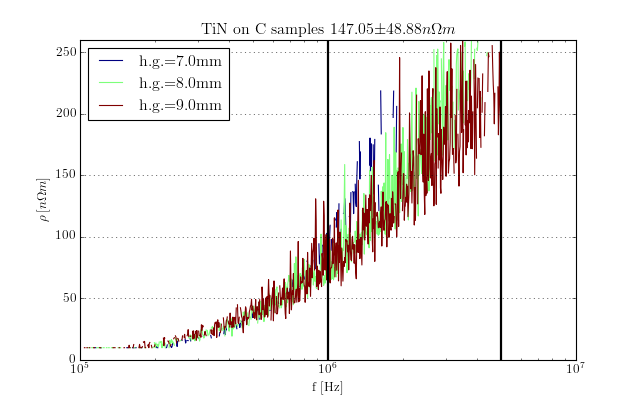

0.007
0.008
0.009


In [51]:
plt.clf()
plt.close('all')
IWDir='/afs/cern.ch/user/n/nbiancac/ln_delphi/ImpedanceWake2D/';
block_scenario='TiN_on_C_samples/';
ref_scenario='Al_samples/'
os.system('mkdir -p '+block_scenario)

hgap_vec=np.arange(7.0,10.0,1.0)*1e-3
rhoDC_vec=np.arange(10.0,270.0,10.)*1e-9
thick_coat=4.7e-6;
rhoDC_bulk=27.5e-6;
thick_bulk=27e-3;
thick_ref=10e-3;

L_sim=1
L_active=123e-3; # length of the blocks

# plots
cols=[plt.cm.jet(ii) for ii in (np.linspace(0,1,len(hgap_vec)))]
flagsave=1

# LXPLUS
lxbatchImp='retrieve'
queue='1nh'

# for conductivity determination
flim=[1e6,5e6]; 

#loop
N=2; # num of windings in coil
Delta=6.3e-3; # full distance coil windings

MeasDir='/afs/cern.ch/work/n/nbiancac/scratch0/RF/TiN_on_C_samples/17-03-2016/thick_probe_N2/'
ResultDir=MeasDir+'Results/'; 
if not os.path.exists(ResultDir): 
    os.mkdir(ResultDir)
    
h_vec=[];leg_vec=[];rho_mean_vec=[];

for hgap in hgap_vec:
    
    imp_mod={}
    imp_mod['sim']={};imp_mod['meas']={}
    imp_mod['sim']['mat']=[]
    imp_mod['sim']['freq']=[]
    imp_mod['meas']['value']=[]
    imp_mod['meas']['freq']=[]
    
    # IW2D simulations for reference block
    freq=freq_param(fmin=1e4,fmax=1e7,ftypescan=2,nflog=20,fadded=[],fmaxrefine=1e7,fminrefine=1.1e7,nrefine=1)
        
    Alu_lay=Alu_layer(thickness=thick_ref)
    vac_lay=vacuum_layer(thickness=np.inf)
    jaw=construct_layers([Alu_lay,vac_lay])
    comment='_HG'+str(hgap*1e3)+'mm'

    dire=ref_scenario+'/'+str(hgap*1e3)+'/';
    iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
    iw_ref,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
    multiply_impedance_wake(iw_ref,L_active/L_sim)
    
    # IW2D simulations for coated block
    for rhoDC in rhoDC_vec:

        Z_lay=Z_layer(rhoDC=rhoDC, thickness=thick_coat)
        bulk_lay=graphite_layer(thickness=thick_bulk)
        bulk_lay.rhoDC=rhoDC_bulk
        vac_lay=vacuum_layer(thickness=np.inf)
        jaw=construct_layers([Z_lay,bulk_lay,vac_lay])
        comment='_HG'+str(hgap*1e3)+'mm_coat-'+str(thick_coat*1e6)+'um-'+str(rhoDC*1e9)+'nOhmm'
        
        dire=block_scenario+'/'+str(hgap*1e3)+'/';
        iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
        iw_block,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
        multiply_impedance_wake(iw_block,L_active/L_sim)
        if lxbatchImp!='launch':
            a,b,c,d,plane,wakeflag=identify_component('Zydip')
            for iw in iw_block:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_block=iw.func[:,0]+1j*iw.func[:,1]
            for iw in iw_ref:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_ref=iw.func[:,0]+1j*iw.func[:,1]
            imp_mod['sim']['mat'].append(Z_block-Z_ref)

    imp_mod['sim']['freq']=freqscan_from_fpar(freq)

    # Measurements
    Block=rf.network.Network((MeasDir+'%dmm/block/TS0.S4P'%(hgap*1e3)))
    Ref=rf.network.Network((MeasDir+'%dmm/ref/TS0.S4P'%(hgap*1e3)))

    imp_mod['meas']['value']=clight/(Block.s11.f*2*pi)*(np.squeeze(Block.s11.z)-np.squeeze(Ref.s11.z))/(N**2)/(Delta**2)
    imp_mod['meas']['freq']=Block.s11.f

    newmat=[];
    for kk in np.arange(0,np.size(imp_mod['sim']['mat'],0)):
        col_re=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.real(imp_mod['sim']['mat'][kk]))
        col_im=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.imag(imp_mod['sim']['mat'][kk]))
        col=col_re+1j*col_im
        newmat.append(col)

    newmat=np.array(newmat)  
    imp_mod['sim']['freq_int']=imp_mod['meas']['freq']
    imp_mod['sim']['mat_int']=newmat


    if lxbatchImp=='retrieve':
        rho_int=[];
        for kk in np.arange(0,np.size(imp_mod['sim']['mat_int'],1)):
            rho_int.append(np.interp(np.real(imp_mod['meas']['value'][kk]),np.real(imp_mod['sim']['mat_int'][:,kk]),rhoDC_vec))

        rho_vec=np.array(rho_int)
        rho_vec[rho_vec==max(rhoDC_vec)]=nan
        
        figure(1,figsize=(8,5))
        h,=plot(imp_mod['sim']['freq_int'],(rho_vec)*1e9, label='h.g.=%.1fmm'%(hgap*1e3),
               c=cols[np.squeeze(np.where(hgap_vec==hgap))])
        xscale('log')
        h_vec.append(h)
        leg_vec.append('h.g.=%.1fmm'%(hgap*1e3))
        print hgap

        
        rho_vec=rho_vec[(imp_mod['sim']['freq_int']>flim[0]) & (imp_mod['sim']['freq_int']<flim[1])]
        rho_mean_vec.append(np.nanmean(rho_vec))

if lxbatchImp=='retrieve':        
    rho_mean=np.nanmean(rho_mean_vec)
    if len(hgap_vec)>1:
        rho_std=np.nanstd(rho_vec)
    else:
        rho_std=np.nanstd(rho_vec)
    axvline(x=flim[0], linewidth=2,color='k')
    axvline(x=flim[1], linewidth=2,color='k')
    ylim(0, np.max(rhoDC_vec*1e9))
    xlim(1e5,1e7)
    xlabel(r'\text{f [Hz]}')
    ylabel(r'\rho\, [n \Omega m]')
    legend(tuple(h_vec),tuple(leg_vec),loc='upper left')
    grid()
    title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f\pm%.2f'%(rho_mean*1e9,rho_std*1e9)+'n \Omega m')

    if flagsave:
        savefig(ResultDir+'rho_vs_f.pdf')
        savefig(ResultDir+'rho_vs_f.png')

<IPython.core.display.Javascript object>


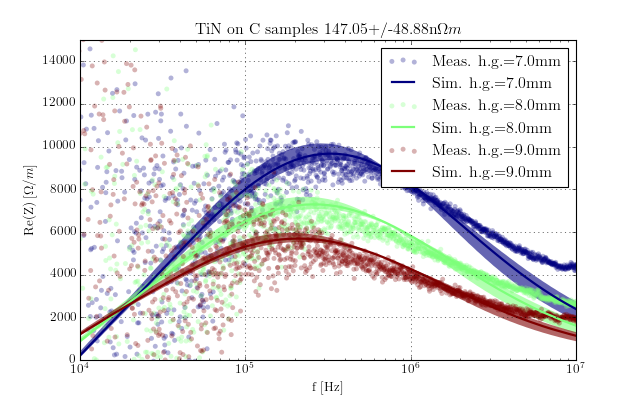

<IPython.core.display.Javascript object>


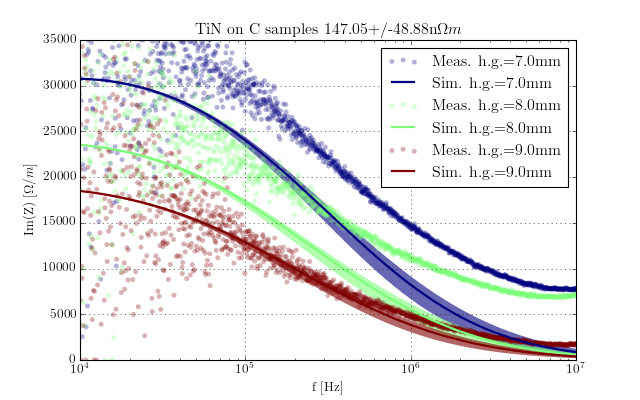

In [50]:
#plot reconstructed
close('all')
rhoDC_vec=np.array([rho_mean,rho_mean+rho_std,rho_mean-rho_std])
lxbatchImp='retrieve'    
h_vec=[];leg_vec=[]; data=[]
cols=[plt.cm.jet(ii) for ii in (np.linspace(0,1,len(hgap_vec)))]
for hgap in hgap_vec:
    
    
    imp_mod={}
    imp_mod['sim']={};imp_mod['meas']={}
    imp_mod['sim']['mat']=[]
    imp_mod['sim']['freq']=[]
    imp_mod['meas']['value']=[]
    imp_mod['meas']['freq']=[]
    
    # IW2D simulations for reference block
    freq=freq_param(fmin=1e4,fmax=1e7,ftypescan=2,nflog=20,fadded=[],fmaxrefine=1e7,fminrefine=1.1e7,nrefine=1)
        
    Alu_lay=Alu_layer(thickness=thick_ref)
    vac_lay=vacuum_layer(thickness=np.inf)
    jaw=construct_layers([Alu_lay,vac_lay])
    comment='_HG'+str(hgap*1e3)+'mm'

    dire=ref_scenario+'/'+str(hgap*1e3)+'/';
    iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
    iw_ref,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
    multiply_impedance_wake(iw_ref,L_active/L_sim)
    
    # IW2D simulations for coated block
    for rhoDC in rhoDC_vec:

        Z_lay=Z_layer(rhoDC=rhoDC, thickness=thick_coat)
        bulk_lay=CFC_layer(thickness=thick_bulk)
        bulk_lay.rhoDC=rhoDC_bulk
        vac_lay=vacuum_layer(thickness=np.inf)
        jaw=construct_layers([Z_lay,bulk_lay,vac_lay])
        comment='_HG'+str(hgap*1e3)+'mm_coat-'+str(thick_coat*1e6)+'um-'+str(rhoDC*1e9)+'nOhmm'
        
        dire=block_scenario+'/'+str(hgap*1e3)+'/';
        iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
        iw_block,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
        multiply_impedance_wake(iw_block,L_active/L_sim)
        if lxbatchImp!='launch':
            a,b,c,d,plane,wakeflag=identify_component('Zydip')
            for iw in iw_block:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_block=iw.func[:,0]+1j*iw.func[:,1]
            for iw in iw_ref:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_ref=iw.func[:,0]+1j*iw.func[:,1]
            imp_mod['sim']['mat'].append(Z_block-Z_ref)
    
    imp_mod['sim']['freq']=freqscan_from_fpar(freq)

    # Measurements
    Block=rf.network.Network((MeasDir+'%dmm/block/TS0.S4P'%(hgap*1e3)))
    Ref=rf.network.Network((MeasDir+'%dmm/ref/TS0.S4P'%(hgap*1e3)))

    imp_mod['meas']['value']=clight/(Block.s11.f*2*pi)*(np.squeeze(Block.s11.z)-np.squeeze(Ref.s11.z))/(N**2)/(Delta**2)
    imp_mod['meas']['freq']=Block.s11.f

    newmat=[];
    for kk in np.arange(0,np.size(imp_mod['sim']['mat'],0)):
        col_re=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.real(imp_mod['sim']['mat'][kk]))
        col_im=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.imag(imp_mod['sim']['mat'][kk]))
        col=col_re+1j*col_im;
        newmat.append(col)

    newmat=np.array(newmat)  
    imp_mod['sim']['freq_int']=imp_mod['meas']['freq']
    imp_mod['sim']['mat_int']=newmat
    
    if lxbatchImp=='retrieve':
        figure(4,figsize=(8,5))
        x=imp_mod['sim']['freq_int']
        scatter(imp_mod['meas']['freq'],np.real(imp_mod['meas']['value']),alpha=0.3,edgecolor='none',               
                   color=cols[np.squeeze(np.where(hgap_vec==hgap))],label='Sim. h.g.=%.1fmm'%(hgap*1e3))
        plot(x,np.real(imp_mod['sim']['mat_int'][0,:]),c=cols[np.squeeze(np.where(hgap_vec==hgap))],
                linewidth=2,label='Meas. h.g.=%.1fmm'%(hgap*1e3))
        fill_between(x, np.real(imp_mod['sim']['mat_int'][1,:]), np.real(imp_mod['sim']['mat_int'][2,:]),
                     facecolor=cols[np.squeeze(np.where(hgap_vec==hgap))], alpha=0.6, edgecolor='none')
        xscale('log')
        xlim(10**4,10**7)
        ylim(0,15e3)
        title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f+/-%.2f'%(rho_mean*1e9,rho_std*1e9)+'n\Omega m')
        xlabel('f [Hz]')
        ylabel('Re(Z) [\Omega/m]')

        figure(5,figsize=(8,5))
        x=imp_mod['sim']['freq_int']
        h=scatter(imp_mod['meas']['freq'],np.imag(imp_mod['meas']['value']),alpha=0.3,edgecolor='none',               
                   color=cols[np.squeeze(np.where(hgap_vec==hgap))],label='Meas. h.g.=%.1fmm'%(hgap*1e3))
        h_vec.append(h)
        leg_vec.append('Meas. h.g.=%.1fmm'%(hgap*1e3))
        h,=plot(x,np.imag(imp_mod['sim']['mat_int'][0,:]),c=cols[np.squeeze(np.where(hgap_vec==hgap))],
                linewidth=2,label='Sim. h.g.=%.1fmm'%(hgap*1e3))
        h_vec.append(h)
        leg_vec.append('Sim. h.g.=%.1fmm'%(hgap*1e3))
        fill_between(x, np.imag(imp_mod['sim']['mat_int'][1,:]), np.imag(imp_mod['sim']['mat_int'][2,:]),
                     facecolor=cols[np.squeeze(np.where(hgap_vec==hgap))], alpha=0.6, edgecolor='none')
        xscale('log')
        xlim(10**4,10**7)
        ylim(0,35e3)
        title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f+/-%.2f'%(rho_mean*1e9,rho_std*1e9)+'n\Omega m')
        xlabel('f [Hz]')
        ylabel('Im(Z) [\Omega/m]')
    

if lxbatchImp=='retrieve':
    figure(4)    
    grid()
    legend(h_vec,leg_vec)
    if flagsave:
        savefig(ResultDir+'reZ_vs_f.pdf')
        savefig(ResultDir+'reZ_vs_f.png')

    figure(5)    
    grid()
    legend(h_vec,leg_vec)
    if flagsave:
        savefig(ResultDir+'imZ_vs_f.pdf')
        savefig(ResultDir+'imZ_vs_f.png')     

## Mo on C - bulk


<IPython.core.display.Javascript object>


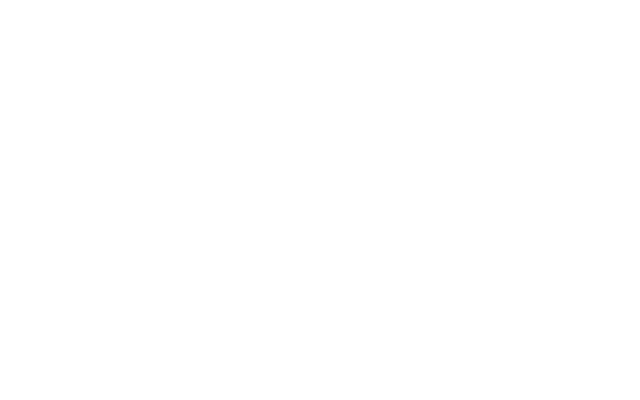

In [29]:
plt.clf()
IWDir='/afs/cern.ch/user/n/nbiancac/ln_delphi/ImpedanceWake2D/';
block_scenario='C_bulk/'
ref_scenario='Al_samples/'

hgap_vec=np.array([7.0,8.0])*1e-3
rhoDC_vec=np.arange(.5,40.5,.5)*1e-6
thick_coat=27e-3
thick_ref=10e-3
L_sim=1
L_active=123e-3; # length of the blocks

# plots
cols=[plt.cm.jet(ii) for ii in (np.linspace(0,1,len(hgap_vec)))]
flagsave=1

# LXPLUS
lxbatchImp='retrieve'
queue='1nh'

# for conductivity determination
flim=[1e6,5e6]; 

#loop
N=2; # num of windings in coil
Delta=6.3e-3; # full distance coil windings

MeasDir='/afs/cern.ch/work/n/nbiancac/scratch0/RF/Graphite-Mo_samples/C_bulk/17-03-2016/thick_probe_N2/'
ResultDir=MeasDir+'Results/'; 
if not os.path.exists(ResultDir): 
    os.mkdir(ResultDir)
    
h_vec=[];leg_vec=[];rho_mean_vec=[];
fig_=figure(figsize=(8,5))
for hgap in hgap_vec:
    
    imp_mod={}
    imp_mod['sim']={};imp_mod['meas']={}
    imp_mod['sim']['mat']=[]
    imp_mod['sim']['freq']=[]
    imp_mod['meas']['value']=[]
    imp_mod['meas']['freq']=[]
    
    # IW2D simulations for reference block
    freq=freq_param(fmin=1e4,fmax=1e7,ftypescan=2,nflog=20,fadded=[],fmaxrefine=1e7,fminrefine=1.1e7,nrefine=1)
        
    Alu_lay=Alu_layer(thickness=thick_ref)
    vac_lay=vacuum_layer(thickness=np.inf)
    jaw=construct_layers([Alu_lay,vac_lay])
    comment='_HG'+str(hgap*1e3)+'mm'

    dire=ref_scenario+'/'+str(hgap*1e3)+'/';
    iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
    iw_ref,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
    multiply_impedance_wake(iw_ref,L_active/L_sim)
    
    # IW2D simulations for coated block
    for rhoDC in rhoDC_vec:

        Z_lay=Z_layer(rhoDC=rhoDC, thickness=thick_coat)
        vac_lay=vacuum_layer(thickness=np.inf)
        jaw=construct_layers([Z_lay,vac_lay])
        comment='_HG'+str(hgap*1e3)+'mm_coat-'+str(thick_coat*1e6)+'um-'+str(rhoDC*1e9)+'nOhmm'
        
        dire=block_scenario+'/'+str(hgap*1e3)+'/';
        iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
        iw_block,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
        multiply_impedance_wake(iw_block,L_active/L_sim)
        if lxbatchImp!='launch':
            a,b,c,d,plane,wakeflag=identify_component('Zydip')
            for iw in iw_block:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_block=iw.func[:,0]+1j*iw.func[:,1]
            for iw in iw_ref:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_ref=iw.func[:,0]+1j*iw.func[:,1]
            imp_mod['sim']['mat'].append(Z_block-Z_ref)

    imp_mod['sim']['freq']=freqscan_from_fpar(freq)

    # Measurements
    Block=rf.network.Network((MeasDir+'%dmm/block/TS0.S4P'%(hgap*1e3)))
    Ref=rf.network.Network((MeasDir+'%dmm/ref/TS0.S4P'%(hgap*1e3)))

    imp_mod['meas']['value']=clight/(Block.s11.f*2*pi)*(np.squeeze(Block.s11.z)-np.squeeze(Ref.s11.z))/(N**2)/(Delta**2)
    imp_mod['meas']['freq']=Block.s11.f

    newmat=[];
    for kk in np.arange(0,np.size(imp_mod['sim']['mat'],0)):
        col=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.real(imp_mod['sim']['mat'][kk]))
        newmat.append(col)

    newmat=np.array(newmat)  
    imp_mod['sim']['freq_int']=imp_mod['meas']['freq']
    imp_mod['sim']['mat_int']=newmat


    if lxbatchImp=='retrieve':
        rho_int=[];
        for kk in np.arange(0,np.size(imp_mod['sim']['mat_int'],1)):
            rho_int.append(np.interp(np.real(imp_mod['meas']['value'][kk]),imp_mod['sim']['mat_int'][:,kk],rhoDC_vec))


        
        h,=semilogx(imp_mod['sim']['freq_int'],np.array(rho_int)*1e6, label='h.g.=%.1fmm'%(hgap*1e3),c=cols[np.squeeze(np.where(hgap_vec==hgap))])
        h_vec.append(h)
        leg_vec.append('h.g.=%.1fmm'%(hgap*1e3))

        rho_vec=np.array(rho_int)
        rho_vec=rho_vec[(imp_mod['sim']['freq_int']>flim[0]) & (imp_mod['sim']['freq_int']<flim[1])]
        rho_mean_vec.append(mean(rho_vec))

rho_mean=mean(rho_mean_vec)
rho_std=std(rho_mean_vec)
axvline(x=flim[0], linewidth=2,color='k')
axvline(x=flim[1], linewidth=2,color='k')
ylim(0, np.max(rhoDC_vec*1e6))
xlim(1e5,1e7)
xlabel(r'\text{f [Hz]}')
ylabel(r'\rho\, [\mu \Omega m]')
legend(tuple(h_vec),tuple(leg_vec))
grid()
title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f\pm%.2f'%(rho_mean*1e6,rho_std*1e6)+'\mu \Omega m')

if flagsave:
    savefig(ResultDir+'rho_vs_f.pdf')
    savefig(ResultDir+'rho_vs_f.png')

<IPython.core.display.Javascript object>


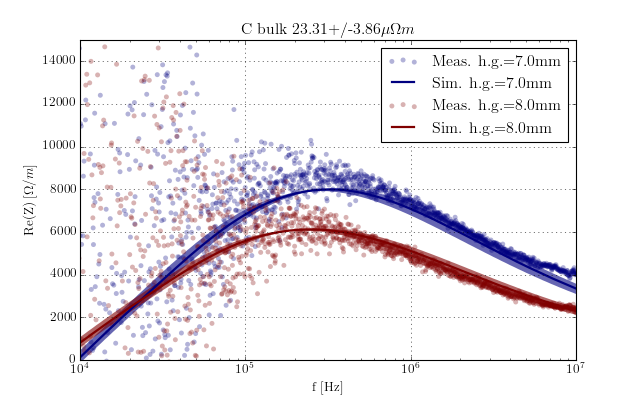

<IPython.core.display.Javascript object>


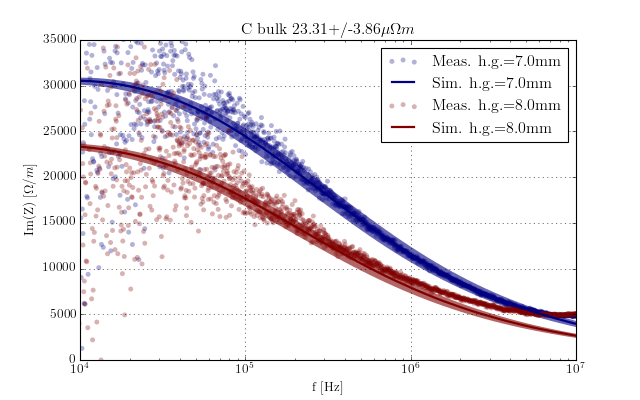

In [32]:
#plot reconstructed
plt.clf()
rhoDC_vec=np.array([rho_mean,rho_mean+rho_std,rho_mean-rho_std])
lxbatchImp='retrieve'    
h_vec=[];leg_vec=[]; data=[]
cols=[plt.cm.jet(ii) for ii in (np.linspace(0,1,len(hgap_vec)))]
for hgap in hgap_vec:
    
    
    imp_mod={}
    imp_mod['sim']={};imp_mod['meas']={}
    imp_mod['sim']['mat']=[]
    imp_mod['sim']['freq']=[]
    imp_mod['meas']['value']=[]
    imp_mod['meas']['freq']=[]
    
    # IW2D simulations for reference block
    freq=freq_param(fmin=1e4,fmax=1e7,ftypescan=2,nflog=20,fadded=[],fmaxrefine=1e7,fminrefine=1.1e7,nrefine=1)
        
    Alu_lay=Alu_layer(thickness=thick_ref)
    vac_lay=vacuum_layer(thickness=np.inf)
    jaw=construct_layers([Alu_lay,vac_lay])
    comment='_HG'+str(hgap*1e3)+'mm'

    dire=ref_scenario+'/'+str(hgap*1e3)+'/';
    iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
    iw_ref,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
    multiply_impedance_wake(iw_ref,L_active/L_sim)
    
    # IW2D simulations for coated block
    for rhoDC in rhoDC_vec:

        Z_lay=Z_layer(rhoDC=rhoDC, thickness=thick_coat)
        vac_lay=vacuum_layer(thickness=np.inf)
        jaw=construct_layers([Z_lay,vac_lay])
        comment='_HG'+str(hgap*1e3)+'mm_coat-'+str(thick_coat*1e6)+'um-'+str(rhoDC*1e9)+'nOhmm'
        
        dire=block_scenario+'/'+str(hgap*1e3)+'/';
        iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
        iw_block,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
        multiply_impedance_wake(iw_block,L_active/L_sim)
        if lxbatchImp!='launch':
            a,b,c,d,plane,wakeflag=identify_component('Zydip')
            for iw in iw_block:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_block=iw.func[:,0]+1j*iw.func[:,1]
            for iw in iw_ref:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_ref=iw.func[:,0]+1j*iw.func[:,1]
            imp_mod['sim']['mat'].append(Z_block-Z_ref)
    
    imp_mod['sim']['freq']=freqscan_from_fpar(freq)

    # Measurements
    Block=rf.network.Network((MeasDir+'%dmm/block/TS0.S4P'%(hgap*1e3)))
    Ref=rf.network.Network((MeasDir+'%dmm/ref/TS0.S4P'%(hgap*1e3)))

    imp_mod['meas']['value']=clight/(Block.s11.f*2*pi)*(np.squeeze(Block.s11.z)-np.squeeze(Ref.s11.z))/(N**2)/(Delta**2)
    imp_mod['meas']['freq']=Block.s11.f

    newmat=[];
    for kk in np.arange(0,np.size(imp_mod['sim']['mat'],0)):
        col_re=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.real(imp_mod['sim']['mat'][kk]))
        col_im=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.imag(imp_mod['sim']['mat'][kk]))
        col=col_re+1j*col_im;
        newmat.append(col)

    newmat=np.array(newmat)  
    imp_mod['sim']['freq_int']=imp_mod['meas']['freq']
    imp_mod['sim']['mat_int']=newmat
    
    if lxbatchImp=='retrieve':
        figure(4,figsize=(8,5))
        x=imp_mod['sim']['freq_int']
        scatter(imp_mod['meas']['freq'],np.real(imp_mod['meas']['value']),alpha=0.3,edgecolor='none',               
                   color=cols[np.squeeze(np.where(hgap_vec==hgap))],label='Sim. h.g.=%.1fmm'%(hgap*1e3))
        plot(x,np.real(imp_mod['sim']['mat_int'][0,:]),c=cols[np.squeeze(np.where(hgap_vec==hgap))],
                linewidth=2,label='Meas. h.g.=%.1fmm'%(hgap*1e3))
        fill_between(x, np.real(imp_mod['sim']['mat_int'][1,:]), np.real(imp_mod['sim']['mat_int'][2,:]),
                     facecolor=cols[np.squeeze(np.where(hgap_vec==hgap))], alpha=0.6, edgecolor='none')
        xscale('log')
        xlim(10**4,10**7)
        ylim(0,15e3)
        title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f+/-%.2f'%(rho_mean*1e6,rho_std*1e6)+'\mu\Omega m')
        xlabel('f [Hz]')
        ylabel('Re(Z) [\Omega/m]')

        figure(5,figsize=(8,5))
        x=imp_mod['sim']['freq_int']
        h=scatter(imp_mod['meas']['freq'],np.imag(imp_mod['meas']['value']),alpha=0.3,edgecolor='none',               
                   color=cols[np.squeeze(np.where(hgap_vec==hgap))],label='Meas. h.g.=%.1fmm'%(hgap*1e3))
        h_vec.append(h)
        leg_vec.append('Meas. h.g.=%.1fmm'%(hgap*1e3))
        h,=plot(x,np.imag(imp_mod['sim']['mat_int'][0,:]),c=cols[np.squeeze(np.where(hgap_vec==hgap))],
                linewidth=2,label='Sim. h.g.=%.1fmm'%(hgap*1e3))
        h_vec.append(h)
        leg_vec.append('Sim. h.g.=%.1fmm'%(hgap*1e3))
        fill_between(x, np.imag(imp_mod['sim']['mat_int'][1,:]), np.imag(imp_mod['sim']['mat_int'][2,:]),
                     facecolor=cols[np.squeeze(np.where(hgap_vec==hgap))], alpha=0.6, edgecolor='none')
        xscale('log')
        xlim(10**4,10**7)
        ylim(0,35e3)
        title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f+/-%.2f'%(rho_mean*1e6,rho_std*1e6)+'\mu\Omega m')
        xlabel('f [Hz]')
        ylabel('Im(Z) [\Omega/m]')
    


figure(4)    
grid()
legend(h_vec,leg_vec)
if flagsave:
    savefig(ResultDir+'reZ_vs_f.pdf')
    savefig(ResultDir+'reZ_vs_f.png')
    
figure(5)    
grid()
legend(h_vec,leg_vec)
if flagsave:
    savefig(ResultDir+'imZ_vs_f.pdf')
    savefig(ResultDir+'imZ_vs_f.png')
    
        

## Mo on C - coating 

<IPython.core.display.Javascript object>


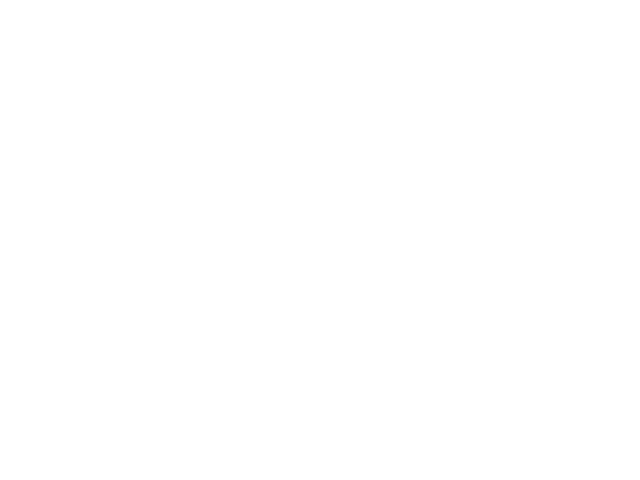

<IPython.core.display.Javascript object>


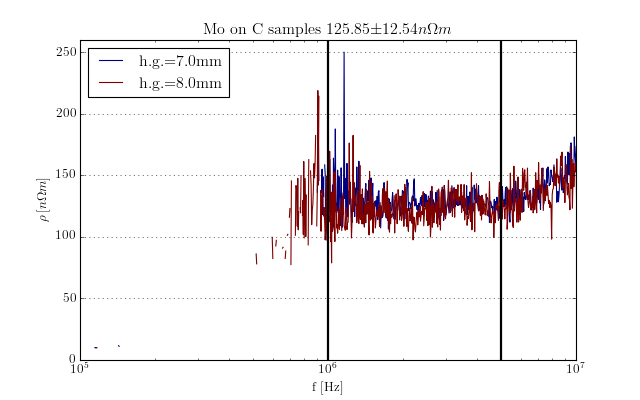

0.007
0.008


In [43]:
plt.clf()
plt.close('all')
IWDir='/afs/cern.ch/user/n/nbiancac/ln_delphi/ImpedanceWake2D/';
block_scenario='Mo_on_C_samples/';
ref_scenario='Al_samples/'
os.system('mkdir -p '+block_scenario)

hgap_vec=np.arange(7.0,9.0,1.0)*1e-3
rhoDC_vec=np.arange(10.0,270.0,10.)*1e-9
thick_coat=7e-6;
rhoDC_bulk=23e-6;
thick_bulk=27e-3;
thick_ref=10e-3;

L_sim=1
L_active=123e-3; # length of the blocks

# plots
cols=[plt.cm.jet(ii) for ii in (np.linspace(0,1,len(hgap_vec)))]
flagsave=1

# LXPLUS
lxbatchImp='retrieve'
queue='1nh'

# for conductivity determination
flim=[1e6,5e6]; 

#loop
N=2; # num of windings in coil
Delta=6.3e-3; # full distance coil windings

MeasDir='/afs/cern.ch/work/n/nbiancac/scratch0/RF/Graphite-Mo_samples/16-03-2016/thick_probe_N2/Delta0cm/'
ResultDir=MeasDir+'Results/'; 
if not os.path.exists(ResultDir): 
    os.mkdir(ResultDir)
    
h_vec=[];leg_vec=[];rho_mean_vec=[];

for hgap in hgap_vec:
    
    imp_mod={}
    imp_mod['sim']={};imp_mod['meas']={}
    imp_mod['sim']['mat']=[]
    imp_mod['sim']['freq']=[]
    imp_mod['meas']['value']=[]
    imp_mod['meas']['freq']=[]
    
    # IW2D simulations for reference block
    freq=freq_param(fmin=1e4,fmax=1e7,ftypescan=2,nflog=20,fadded=[],fmaxrefine=1e7,fminrefine=1.1e7,nrefine=1)
        
    Alu_lay=Alu_layer(thickness=thick_ref)
    vac_lay=vacuum_layer(thickness=np.inf)
    jaw=construct_layers([Alu_lay,vac_lay])
    comment='_HG'+str(hgap*1e3)+'mm'

    dire=ref_scenario+'/'+str(hgap*1e3)+'/';
    iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
    iw_ref,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
    multiply_impedance_wake(iw_ref,L_active/L_sim)
    
    # IW2D simulations for coated block
    for rhoDC in rhoDC_vec:

        Z_lay=Z_layer(rhoDC=rhoDC, thickness=thick_coat)
        bulk_lay=graphite_layer(thickness=thick_bulk)
        bulk_lay.rhoDC=rhoDC_bulk
        vac_lay=vacuum_layer(thickness=np.inf)
        jaw=construct_layers([Z_lay,bulk_lay,vac_lay])
        comment='_HG'+str(hgap*1e3)+'mm_coat-'+str(thick_coat*1e6)+'um-'+str(rhoDC*1e9)+'nOhmm'
        
        dire=block_scenario+'/'+str(hgap*1e3)+'/';
        iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
        iw_block,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
        multiply_impedance_wake(iw_block,L_active/L_sim)
        if lxbatchImp!='launch':
            a,b,c,d,plane,wakeflag=identify_component('Zydip')
            for iw in iw_block:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_block=iw.func[:,0]+1j*iw.func[:,1]
            for iw in iw_ref:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_ref=iw.func[:,0]+1j*iw.func[:,1]
            imp_mod['sim']['mat'].append(Z_block-Z_ref)

    imp_mod['sim']['freq']=freqscan_from_fpar(freq)

    # Measurements
    Block=rf.network.Network((MeasDir+'%dmm/block/TS0.S4P'%(hgap*1e3)))
    Ref=rf.network.Network((MeasDir+'%dmm/ref/TS0.S4P'%(hgap*1e3)))

    imp_mod['meas']['value']=clight/(Block.s11.f*2*pi)*(np.squeeze(Block.s11.z)-np.squeeze(Ref.s11.z))/(N**2)/(Delta**2)
    imp_mod['meas']['freq']=Block.s11.f

    newmat=[];
    for kk in np.arange(0,np.size(imp_mod['sim']['mat'],0)):
        col_re=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.real(imp_mod['sim']['mat'][kk]))
        col_im=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.imag(imp_mod['sim']['mat'][kk]))
        col=col_re+1j*col_im
        newmat.append(col)

    newmat=np.array(newmat)  
    imp_mod['sim']['freq_int']=imp_mod['meas']['freq']
    imp_mod['sim']['mat_int']=newmat


    if lxbatchImp=='retrieve':
        rho_int=[];
        for kk in np.arange(0,np.size(imp_mod['sim']['mat_int'],1)):
            rho_int.append(np.interp(np.real(imp_mod['meas']['value'][kk]),np.real(imp_mod['sim']['mat_int'][:,kk]),rhoDC_vec))

        rho_vec=np.array(rho_int)
        rho_vec[rho_vec==max(rhoDC_vec)]=nan
        
        figure(num=1,figsize=(8,5))
        h,=plot(imp_mod['sim']['freq_int'],(rho_vec)*1e9, label='h.g.=%.1fmm'%(hgap*1e3),
               c=cols[np.squeeze(np.where(hgap_vec==hgap))])
        xscale('log')
        h_vec.append(h)
        leg_vec.append('h.g.=%.1fmm'%(hgap*1e3))
        print hgap

        
        rho_vec=rho_vec[(imp_mod['sim']['freq_int']>flim[0]) & (imp_mod['sim']['freq_int']<flim[1])]
        rho_mean_vec.append(np.nanmean(rho_vec))

if lxbatchImp=='retrieve':        
    rho_mean=np.nanmean(rho_mean_vec)
    if len(hgap_vec)>1:
        rho_std=np.nanstd(rho_vec)
    else:
        rho_std=np.nanstd(rho_vec)
    axvline(x=flim[0], linewidth=2,color='k')
    axvline(x=flim[1], linewidth=2,color='k')
    ylim(0, np.max(rhoDC_vec*1e9))
    xlim(1e5,1e7)
    xlabel(r'\text{f [Hz]}')
    ylabel(r'\rho\, [n \Omega m]')
    legend(tuple(h_vec),tuple(leg_vec),loc='upper left')
    grid()
    title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f\pm%.2f'%(rho_mean*1e9,rho_std*1e9)+'n \Omega m')

    if flagsave:
        savefig(ResultDir+'rho_vs_f.pdf')
        savefig(ResultDir+'rho_vs_f.png')

<IPython.core.display.Javascript object>


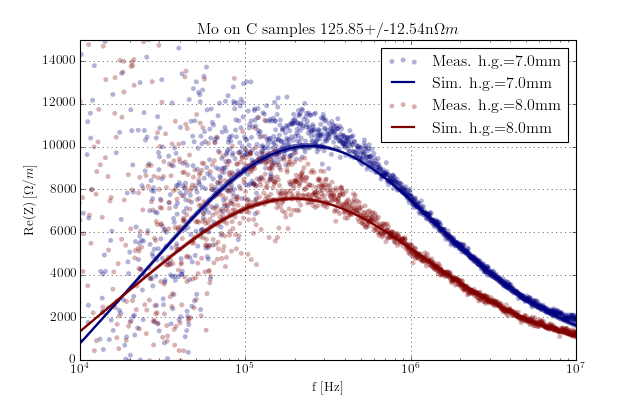

<IPython.core.display.Javascript object>


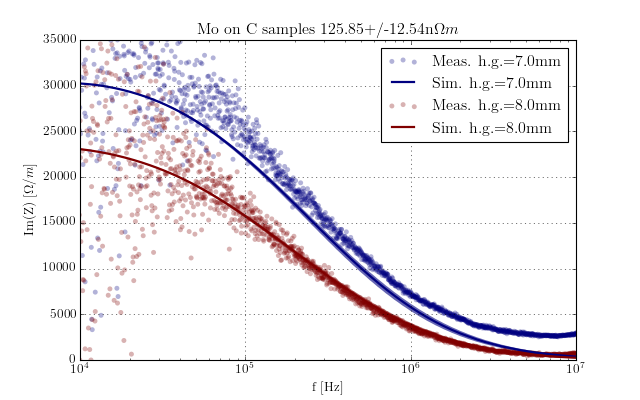

In [47]:
#plot reconstructed
close('all')
rhoDC_vec=np.array([rho_mean,rho_mean+rho_std,rho_mean-rho_std])
lxbatchImp='retrieve'    
h_vec=[];leg_vec=[]; data=[]
cols=[plt.cm.jet(ii) for ii in (np.linspace(0,1,len(hgap_vec)))]
for hgap in hgap_vec:
    
    
    imp_mod={}
    imp_mod['sim']={};imp_mod['meas']={}
    imp_mod['sim']['mat']=[]
    imp_mod['sim']['freq']=[]
    imp_mod['meas']['value']=[]
    imp_mod['meas']['freq']=[]
    
    # IW2D simulations for reference block
    freq=freq_param(fmin=1e4,fmax=1e7,ftypescan=2,nflog=20,fadded=[],fmaxrefine=1e7,fminrefine=1.1e7,nrefine=1)
        
    Alu_lay=Alu_layer(thickness=thick_ref)
    vac_lay=vacuum_layer(thickness=np.inf)
    jaw=construct_layers([Alu_lay,vac_lay])
    comment='_HG'+str(hgap*1e3)+'mm'

    dire=ref_scenario+'/'+str(hgap*1e3)+'/';
    iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
    iw_ref,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
    multiply_impedance_wake(iw_ref,L_active/L_sim)
    
    # IW2D simulations for coated block
    for rhoDC in rhoDC_vec:

        Z_lay=Z_layer(rhoDC=rhoDC, thickness=thick_coat)
        bulk_lay=graphite_layer(thickness=thick_bulk)
        bulk_lay.rhoDC=rhoDC_bulk
        vac_lay=vacuum_layer(thickness=np.inf)
        jaw=construct_layers([Z_lay,bulk_lay,vac_lay])
        comment='_HG'+str(hgap*1e3)+'mm_coat-'+str(thick_coat*1e6)+'um-'+str(rhoDC*1e9)+'nOhmm'
        
        dire=block_scenario+'/'+str(hgap*1e3)+'/';
        iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
        iw_block,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
        multiply_impedance_wake(iw_block,L_active/L_sim)
        if lxbatchImp!='launch':
            a,b,c,d,plane,wakeflag=identify_component('Zydip')
            for iw in iw_block:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_block=iw.func[:,0]+1j*iw.func[:,1]
            for iw in iw_ref:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_ref=iw.func[:,0]+1j*iw.func[:,1]
            imp_mod['sim']['mat'].append(Z_block-Z_ref)
    
    imp_mod['sim']['freq']=freqscan_from_fpar(freq)

    # Measurements
    Block=rf.network.Network((MeasDir+'%dmm/block/TS0.S4P'%(hgap*1e3)))
    Ref=rf.network.Network((MeasDir+'%dmm/ref/TS0.S4P'%(hgap*1e3)))

    imp_mod['meas']['value']=clight/(Block.s11.f*2*pi)*(np.squeeze(Block.s11.z)-np.squeeze(Ref.s11.z))/(N**2)/(Delta**2)
    imp_mod['meas']['freq']=Block.s11.f

    newmat=[];
    for kk in np.arange(0,np.size(imp_mod['sim']['mat'],0)):
        col_re=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.real(imp_mod['sim']['mat'][kk]))
        col_im=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.imag(imp_mod['sim']['mat'][kk]))
        col=col_re+1j*col_im;
        newmat.append(col)

    newmat=np.array(newmat)  
    imp_mod['sim']['freq_int']=imp_mod['meas']['freq']
    imp_mod['sim']['mat_int']=newmat
    
    if lxbatchImp=='retrieve':
        figure(4,figsize=(8,5))
        x=imp_mod['sim']['freq_int']
        scatter(imp_mod['meas']['freq'],np.real(imp_mod['meas']['value']),alpha=0.3,edgecolor='none',               
                   color=cols[np.squeeze(np.where(hgap_vec==hgap))],label='Sim. h.g.=%.1fmm'%(hgap*1e3))
        plot(x,np.real(imp_mod['sim']['mat_int'][0,:]),c=cols[np.squeeze(np.where(hgap_vec==hgap))],
                linewidth=2,label='Meas. h.g.=%.1fmm'%(hgap*1e3))
        fill_between(x, np.real(imp_mod['sim']['mat_int'][1,:]), np.real(imp_mod['sim']['mat_int'][2,:]),
                     facecolor=cols[np.squeeze(np.where(hgap_vec==hgap))], alpha=0.6, edgecolor='none')
        xscale('log')
        xlim(10**4,10**7)
        ylim(0,15e3)
        title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f+/-%.2f'%(rho_mean*1e9,rho_std*1e9)+'n\Omega m')
        xlabel('f [Hz]')
        ylabel('Re(Z) [\Omega/m]')

        figure(5,figsize=(8,5))
        x=imp_mod['sim']['freq_int']
        h=scatter(imp_mod['meas']['freq'],np.imag(imp_mod['meas']['value']),alpha=0.3,edgecolor='none',               
                   color=cols[np.squeeze(np.where(hgap_vec==hgap))],label='Meas. h.g.=%.1fmm'%(hgap*1e3))
        h_vec.append(h)
        leg_vec.append('Meas. h.g.=%.1fmm'%(hgap*1e3))
        h,=plot(x,np.imag(imp_mod['sim']['mat_int'][0,:]),c=cols[np.squeeze(np.where(hgap_vec==hgap))],
                linewidth=2,label='Sim. h.g.=%.1fmm'%(hgap*1e3))
        h_vec.append(h)
        leg_vec.append('Sim. h.g.=%.1fmm'%(hgap*1e3))
        fill_between(x, np.imag(imp_mod['sim']['mat_int'][1,:]), np.imag(imp_mod['sim']['mat_int'][2,:]),
                     facecolor=cols[np.squeeze(np.where(hgap_vec==hgap))], alpha=0.6, edgecolor='none')
        xscale('log')
        xlim(10**4,10**7)
        ylim(0,35e3)
        title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f+/-%.2f'%(rho_mean*1e9,rho_std*1e9)+'n\Omega m')
        xlabel('f [Hz]')
        ylabel('Im(Z) [\Omega/m]')
    

if lxbatchImp=='retrieve':
    figure(4)    
    grid()
    legend(h_vec,leg_vec)
    if flagsave:
        savefig(ResultDir+'reZ_vs_f.pdf')
        savefig(ResultDir+'reZ_vs_f.png')

    figure(5)    
    grid()
    legend(h_vec,leg_vec)
    if flagsave:
        savefig(ResultDir+'imZ_vs_f.pdf')
        savefig(ResultDir+'imZ_vs_f.png')     

## Cu stripe on CFC block

<IPython.core.display.Javascript object>


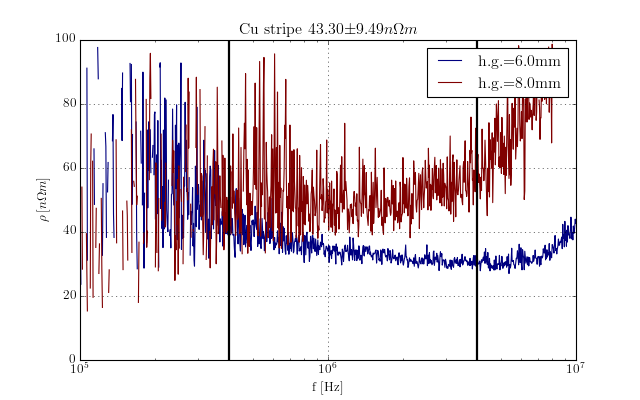

0.006
0.008


In [92]:
close('all')
IWDir='/afs/cern.ch/user/n/nbiancac/ln_delphi/ImpedanceWake2D/';
block_scenario='Cu_stripe/';
ref_scenario='Al_samples/'
os.system('mkdir -p '+block_scenario)

hgap_vec=np.array([6.0,8.0])*1e-3
rhoDC_vec=np.arange(10.0,110.0,10.)*1e-9
thick_coat=2e-6;
rhoDC_bulk=7e-6;
thick_bulk=27e-3;
thick_ref=10e-3;

L_sim=1
L_active=123e-3; # length of the blocks

# plots
cols=[plt.cm.jet(ii) for ii in (np.linspace(0,1,len(hgap_vec)))]
flagsave=1

# LXPLUS
lxbatchImp='retrieve'
queue='1nh'

# for conductivity determination
flim=[4e5,4e6]; 

#loop
N=2; # num of windings in coil
Delta=6.3e-3; # full distance coil windings

MeasDir='/afs/cern.ch/user/n/nbiancac/ln_work/scratch0/RF/CFC_3coated_sample/Cu_stripe/16-03-2016/thick_probe_N2/'
ResultDir=MeasDir+'Results/'; 
if not os.path.exists(ResultDir): 
    os.mkdir(ResultDir)
    
h_vec=[];leg_vec=[];rho_mean_vec=[];

for hgap in hgap_vec:
    
    imp_mod={}
    imp_mod['sim']={};imp_mod['meas']={}
    imp_mod['sim']['mat']=[]
    imp_mod['sim']['freq']=[]
    imp_mod['meas']['value']=[]
    imp_mod['meas']['freq']=[]
    
    # IW2D simulations for reference block
    freq=freq_param(fmin=1e4,fmax=1e7,ftypescan=2,nflog=20,fadded=[],fmaxrefine=1e7,fminrefine=1.1e7,nrefine=1)
        
    Alu_lay=Alu_layer(thickness=thick_ref)
    vac_lay=vacuum_layer(thickness=np.inf)
    jaw=construct_layers([Alu_lay,vac_lay])
    comment='_HG'+str(hgap*1e3)+'mm'

    dire=ref_scenario+'/'+str(hgap*1e3)+'/';
    iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
    iw_ref,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
    multiply_impedance_wake(iw_ref,L_active/L_sim)
    
    # IW2D simulations for coated block
    for rhoDC in rhoDC_vec:

        Z_lay=Z_layer(rhoDC=rhoDC, thickness=thick_coat)
        bulk_lay=CFC_layer(thickness=thick_bulk)
        bulk_lay.rhoDC=rhoDC_bulk
        vac_lay=vacuum_layer(thickness=np.inf)
        jaw=construct_layers([Z_lay,bulk_lay,vac_lay])
        comment='_HG'+str(hgap*1e3)+'mm_coat-'+str(thick_coat*1e6)+'um-'+str(rhoDC*1e9)+'nOhmm'
        
        dire=block_scenario+'/'+str(hgap*1e3)+'/';
        iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
        iw_block,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
        multiply_impedance_wake(iw_block,L_active/L_sim)
        if lxbatchImp!='launch':
            a,b,c,d,plane,wakeflag=identify_component('Zydip')
            for iw in iw_block:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_block=iw.func[:,0]+1j*iw.func[:,1]
            for iw in iw_ref:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_ref=iw.func[:,0]+1j*iw.func[:,1]
            imp_mod['sim']['mat'].append(Z_block-Z_ref)

    imp_mod['sim']['freq']=freqscan_from_fpar(freq)

    # Measurements
    Block=rf.network.Network((MeasDir+'%dmm/block/TS0.S4P'%(np.round(hgap*1e3))))
    Ref=rf.network.Network((MeasDir+'%dmm/ref/TS0.S4P'%(np.round(hgap*1e3))))

    imp_mod['meas']['value']=clight/(Block.s11.f*2*pi)*(np.squeeze(Block.s11.z)-np.squeeze(Ref.s11.z))/(N**2)/(Delta**2)
    imp_mod['meas']['freq']=Block.s11.f

    newmat=[];
    for kk in np.arange(0,np.size(imp_mod['sim']['mat'],0)):
        col_re=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.real(imp_mod['sim']['mat'][kk]))
        col_im=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.imag(imp_mod['sim']['mat'][kk]))
        col=col_re+1j*col_im
        newmat.append(col)

    newmat=np.array(newmat)  
    imp_mod['sim']['freq_int']=imp_mod['meas']['freq']
    imp_mod['sim']['mat_int']=newmat


    if lxbatchImp=='retrieve':
        rho_int=[];
        for kk in np.arange(0,np.size(imp_mod['sim']['mat_int'],1)):
            rho_int.append(np.interp(np.imag(imp_mod['meas']['value'][kk]),np.imag(imp_mod['sim']['mat_int'][:,kk]),rhoDC_vec))

        rho_vec=np.array(rho_int)
        rho_vec[rho_vec==max(rhoDC_vec)]=nan
        
        figure(1,figsize=(8,5))
        h,=plot(imp_mod['sim']['freq_int'],(rho_vec)*1e9, label='h.g.=%.1fmm'%(hgap*1e3),
               c=cols[np.squeeze(np.where(hgap_vec==hgap))])
        xscale('log')
        h_vec.append(h)
        leg_vec.append('h.g.=%.1fmm'%(hgap*1e3))
        print hgap

        
        rho_vec=rho_vec[(imp_mod['sim']['freq_int']>flim[0]) & (imp_mod['sim']['freq_int']<flim[1])]
        rho_mean_vec.append(np.nanmean(rho_vec))

if lxbatchImp=='retrieve':        
    rho_mean=np.nanmean(rho_mean_vec)
    if len(hgap_vec)>1:
        rho_std=np.nanstd(rho_vec)
    else:
        rho_std=np.nanstd(rho_vec)
    axvline(x=flim[0], linewidth=2,color='k')
    axvline(x=flim[1], linewidth=2,color='k')
    ylim(0, np.max(rhoDC_vec*1e9))
    xlim(1e5,1e7)
    xlabel(r'\text{f [Hz]}')
    ylabel(r'\rho\, [n \Omega m]')
    legend(tuple(h_vec),tuple(leg_vec),loc='upper right')
    grid()
    title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f\pm%.2f'%(rho_mean*1e9,rho_std*1e9)+'n \Omega m')


    print ResultDir
    savefig(ResultDir+'rho_vs_f.pdf')
    savefig(ResultDir+'rho_vs_f.png')

<IPython.core.display.Javascript object>


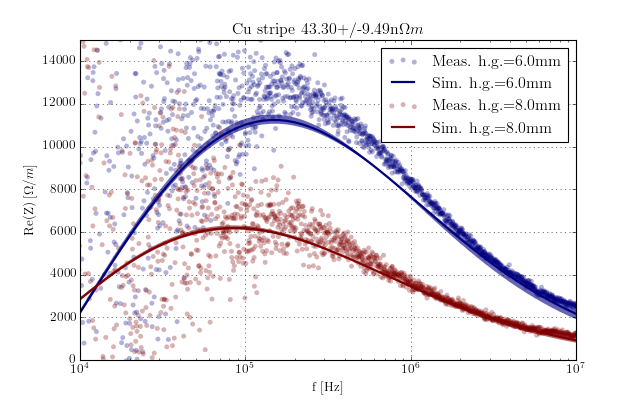

<IPython.core.display.Javascript object>


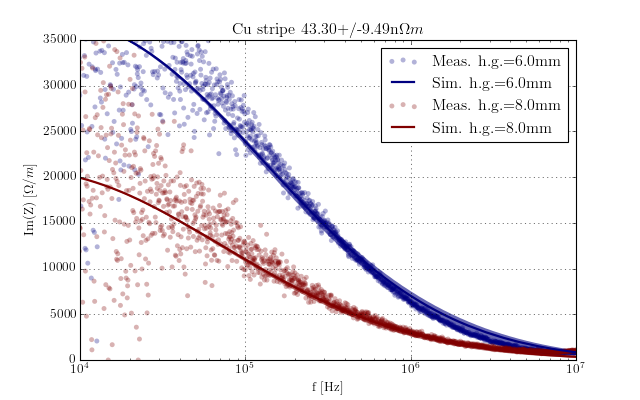

/afs/cern.ch/user/n/nbiancac/ln_work/scratch0/RF/CFC_3coated_sample/Cu_stripe/16-03-2016/thick_probe_N2/Results/reZ_vs_f.pdf
/afs/cern.ch/user/n/nbiancac/ln_work/scratch0/RF/CFC_3coated_sample/Cu_stripe/16-03-2016/thick_probe_N2/Results/imZ_vs_f.pdf


In [95]:
#plot reconstructed
close('all')
rhoDC_vec=np.array([rho_mean,rho_mean+rho_std,rho_mean-rho_std])
lxbatchImp='retrieve'    
h_vec=[];leg_vec=[]; data=[]
cols=[plt.cm.jet(ii) for ii in (np.linspace(0,1,len(hgap_vec)))]
for hgap in hgap_vec:
    
    
    imp_mod={}
    imp_mod['sim']={};imp_mod['meas']={}
    imp_mod['sim']['mat']=[]
    imp_mod['sim']['freq']=[]
    imp_mod['meas']['value']=[]
    imp_mod['meas']['freq']=[]
    
    # IW2D simulations for reference block
    freq=freq_param(fmin=1e4,fmax=1e7,ftypescan=2,nflog=20,fadded=[],fmaxrefine=1e7,fminrefine=1.1e7,nrefine=1)
        
    Alu_lay=Alu_layer(thickness=thick_ref)
    vac_lay=vacuum_layer(thickness=np.inf)
    jaw=construct_layers([Alu_lay,vac_lay])
    comment='_HG'+str(hgap*1e3)+'mm'

    dire=ref_scenario+'/'+str(hgap*1e3)+'/';
    iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
    iw_ref,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
    multiply_impedance_wake(iw_ref,L_active/L_sim)
    
    # IW2D simulations for coated block
    for rhoDC in rhoDC_vec:

        Z_lay=Z_layer(rhoDC=rhoDC, thickness=thick_coat)
        bulk_lay=CFC_layer(thickness=thick_bulk)
        bulk_lay.rhoDC=rhoDC_bulk
        vac_lay=vacuum_layer(thickness=np.inf)
        jaw=construct_layers([Z_lay,bulk_lay,vac_lay])
        comment='_HG'+str(hgap*1e3)+'mm_coat-'+str(thick_coat*1e6)+'um-'+str(rhoDC*1e9)+'nOhmm'
        
        dire=block_scenario+'/'+str(hgap*1e3)+'/';
        iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
        iw_block,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
        multiply_impedance_wake(iw_block,L_active/L_sim)
        if lxbatchImp!='launch':
            a,b,c,d,plane,wakeflag=identify_component('Zydip')
            for iw in iw_block:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_block=iw.func[:,0]+1j*iw.func[:,1]
            for iw in iw_ref:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_ref=iw.func[:,0]+1j*iw.func[:,1]
            imp_mod['sim']['mat'].append(Z_block-Z_ref)
    
    imp_mod['sim']['freq']=freqscan_from_fpar(freq)

    # Measurements
    Block=rf.network.Network((MeasDir+'%dmm/block/TS0.S4P'%(np.round(hgap*1e3))))
    Ref=rf.network.Network((MeasDir+'%dmm/ref/TS0.S4P'%(np.round(hgap*1e3))))

    imp_mod['meas']['value']=clight/(Block.s11.f*2*pi)*(np.squeeze(Block.s11.z)-np.squeeze(Ref.s11.z))/(N**2)/(Delta**2)
    imp_mod['meas']['freq']=Block.s11.f

    newmat=[];
    for kk in np.arange(0,np.size(imp_mod['sim']['mat'],0)):
        col_re=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.real(imp_mod['sim']['mat'][kk]))
        col_im=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.imag(imp_mod['sim']['mat'][kk]))
        col=col_re+1j*col_im;
        newmat.append(col)

    newmat=np.array(newmat)  
    imp_mod['sim']['freq_int']=imp_mod['meas']['freq']
    imp_mod['sim']['mat_int']=newmat
    
    if lxbatchImp=='retrieve':
        figure(4,figsize=(8,5))
        x=imp_mod['sim']['freq_int']
        scatter(imp_mod['meas']['freq'],np.real(imp_mod['meas']['value']),alpha=0.3,edgecolor='none',               
                   color=cols[np.squeeze(np.where(hgap_vec==hgap))],label='Sim. h.g.=%.1fmm'%(hgap*1e3))
        plot(x,np.real(imp_mod['sim']['mat_int'][0,:]),c=cols[np.squeeze(np.where(hgap_vec==hgap))],
                linewidth=2,label='Meas. h.g.=%.1fmm'%(hgap*1e3))
        fill_between(x, np.real(imp_mod['sim']['mat_int'][1,:]), np.real(imp_mod['sim']['mat_int'][2,:]),
                     facecolor=cols[np.squeeze(np.where(hgap_vec==hgap))], alpha=0.6, edgecolor='none')
        xscale('log')
        xlim(10**4,10**7)
        ylim(0,15e3)
        title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f+/-%.2f'%(rho_mean*1e9,rho_std*1e9)+'n\Omega m')
        xlabel('f [Hz]')
        ylabel('Re(Z) [\Omega/m]')

        figure(5,figsize=(8,5))
        x=imp_mod['sim']['freq_int']
        h=scatter(imp_mod['meas']['freq'],np.imag(imp_mod['meas']['value']),alpha=0.3,edgecolor='none',               
                   color=cols[np.squeeze(np.where(hgap_vec==hgap))],label='Meas. h.g.=%.1fmm'%(hgap*1e3))
        h_vec.append(h)
        leg_vec.append('Meas. h.g.=%.1fmm'%(hgap*1e3))
        h,=plot(x,np.imag(imp_mod['sim']['mat_int'][0,:]),c=cols[np.squeeze(np.where(hgap_vec==hgap))],
                linewidth=2,label='Sim. h.g.=%.1fmm'%(hgap*1e3))
        h_vec.append(h)
        leg_vec.append('Sim. h.g.=%.1fmm'%(hgap*1e3))
        fill_between(x, np.imag(imp_mod['sim']['mat_int'][1,:]), np.imag(imp_mod['sim']['mat_int'][2,:]),
                     facecolor=cols[np.squeeze(np.where(hgap_vec==hgap))], alpha=0.6, edgecolor='none')
        xscale('log')
        xlim(10**4,10**7)
        ylim(0,35e3)
        title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f+/-%.2f'%(rho_mean*1e9,rho_std*1e9)+'n\Omega m')
        xlabel('f [Hz]')
        ylabel('Im(Z) [\Omega/m]')
    

if lxbatchImp=='retrieve':
    figure(4)    
    grid()
    legend(h_vec,leg_vec)
    if flagsave:
        print ResultDir+'reZ_vs_f.pdf'
        savefig(ResultDir+'reZ_vs_f.pdf')
        savefig(ResultDir+'reZ_vs_f.png')

    figure(5)    
    grid()
    legend(h_vec,leg_vec)
    if flagsave:
        print ResultDir+'imZ_vs_f.pdf'
        savefig(ResultDir+'imZ_vs_f.pdf')
        savefig(ResultDir+'imZ_vs_f.png')     

## Mo stripe on CFC

<IPython.core.display.Javascript object>


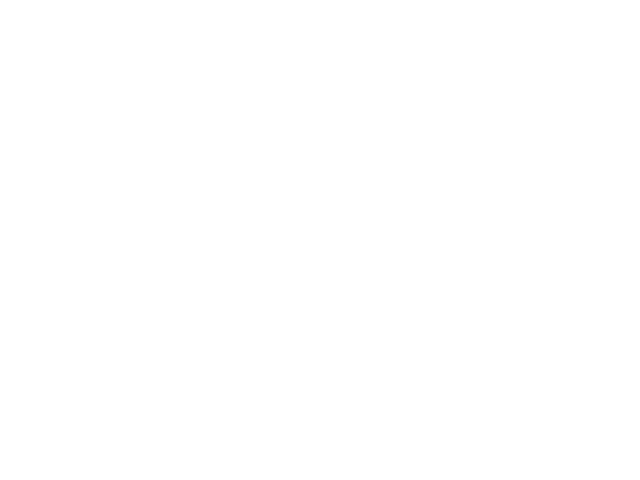

<IPython.core.display.Javascript object>


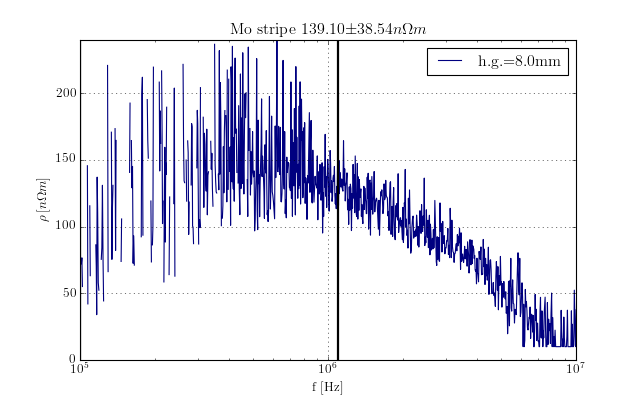

0.008
/afs/cern.ch/user/n/nbiancac/ln_work/scratch0/RF/CFC_3coated_sample/Mo_stripe/16-03-2016/thick_probe_N2/Results/


In [77]:
close('all')
IWDir='/afs/cern.ch/user/n/nbiancac/ln_delphi/ImpedanceWake2D/';
block_scenario='Mo_stripe/';
ref_scenario='Al_samples/'
os.system('mkdir -p '+block_scenario)

hgap_vec=np.arange(8.0,9.0,1.0)*1e-3
rhoDC_vec=np.arange(10.0,250.0,10.)*1e-9
thick_coat=7e-6;
rhoDC_bulk=7e-6;
thick_bulk=27e-3;
thick_ref=10e-3;

L_sim=1
L_active=123e-3; # length of the blocks

# plots
cols=[plt.cm.jet(ii) for ii in (np.linspace(0,1,len(hgap_vec)))]
flagsave=1

# LXPLUS
lxbatchImp='retrieve'
queue='1nh'

# for conductivity determination
flim=[1e5,1.1e6]; 

#loop
N=2; # num of windings in coil
Delta=6.3e-3; # full distance coil windings

MeasDir='/afs/cern.ch/user/n/nbiancac/ln_work/scratch0/RF/CFC_3coated_sample/Mo_stripe/16-03-2016/thick_probe_N2/'
ResultDir=MeasDir+'Results/'; 
if not os.path.exists(ResultDir): 
    os.mkdir(ResultDir)
    
h_vec=[];leg_vec=[];rho_mean_vec=[];

for hgap in hgap_vec:
    
    imp_mod={}
    imp_mod['sim']={};imp_mod['meas']={}
    imp_mod['sim']['mat']=[]
    imp_mod['sim']['freq']=[]
    imp_mod['meas']['value']=[]
    imp_mod['meas']['freq']=[]
    
    # IW2D simulations for reference block
    freq=freq_param(fmin=1e4,fmax=1e7,ftypescan=2,nflog=20,fadded=[],fmaxrefine=1e7,fminrefine=1.1e7,nrefine=1)
        
    Alu_lay=Alu_layer(thickness=thick_ref)
    vac_lay=vacuum_layer(thickness=np.inf)
    jaw=construct_layers([Alu_lay,vac_lay])
    comment='_HG'+str(hgap*1e3)+'mm'

    dire=ref_scenario+'/'+str(hgap*1e3)+'/';
    iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
    iw_ref,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
    multiply_impedance_wake(iw_ref,L_active/L_sim)
    
    # IW2D simulations for coated block
    for rhoDC in rhoDC_vec:

        Z_lay=Z_layer(rhoDC=rhoDC, thickness=thick_coat)
        bulk_lay=CFC_layer(thickness=thick_bulk)
        bulk_lay.rhoDC=rhoDC_bulk
        vac_lay=vacuum_layer(thickness=np.inf)
        jaw=construct_layers([Z_lay,bulk_lay,vac_lay])
        comment='_HG'+str(hgap*1e3)+'mm_coat-'+str(thick_coat*1e6)+'um-'+str(rhoDC*1e9)+'nOhmm'
        
        dire=block_scenario+'/'+str(hgap*1e3)+'/';
        iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
        iw_block,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
        multiply_impedance_wake(iw_block,L_active/L_sim)
        if lxbatchImp!='launch':
            a,b,c,d,plane,wakeflag=identify_component('Zydip')
            for iw in iw_block:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_block=iw.func[:,0]+1j*iw.func[:,1]
            for iw in iw_ref:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_ref=iw.func[:,0]+1j*iw.func[:,1]
            imp_mod['sim']['mat'].append(Z_block-Z_ref)

    imp_mod['sim']['freq']=freqscan_from_fpar(freq)

    # Measurements
    Block=rf.network.Network((MeasDir+'%dmm/block/TS0.S4P'%(np.round(hgap*1e3))))
    Ref=rf.network.Network((MeasDir+'%dmm/ref/TS0.S4P'%(np.round(hgap*1e3))))

    imp_mod['meas']['value']=clight/(Block.s11.f*2*pi)*(np.squeeze(Block.s11.z)-np.squeeze(Ref.s11.z))/(N**2)/(Delta**2)
    imp_mod['meas']['freq']=Block.s11.f

    newmat=[];
    for kk in np.arange(0,np.size(imp_mod['sim']['mat'],0)):
        col_re=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.real(imp_mod['sim']['mat'][kk]))
        col_im=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.imag(imp_mod['sim']['mat'][kk]))
        col=col_re+1j*col_im
        newmat.append(col)

    newmat=np.array(newmat)  
    imp_mod['sim']['freq_int']=imp_mod['meas']['freq']
    imp_mod['sim']['mat_int']=newmat


    if lxbatchImp=='retrieve':
        rho_int=[];
        for kk in np.arange(0,np.size(imp_mod['sim']['mat_int'],1)):
            rho_int.append(np.interp(np.imag(imp_mod['meas']['value'][kk]),np.imag(imp_mod['sim']['mat_int'][:,kk]),rhoDC_vec))

        rho_vec=np.array(rho_int)
        rho_vec[rho_vec==max(rhoDC_vec)]=nan
        
        figure(1,figsize=(8,5))
        h,=plot(imp_mod['sim']['freq_int'],(rho_vec)*1e9, label='h.g.=%.1fmm'%(hgap*1e3),
               c=cols[np.squeeze(np.where(hgap_vec==hgap))])
        xscale('log')
        h_vec.append(h)
        leg_vec.append('h.g.=%.1fmm'%(hgap*1e3))
        print hgap

        
        rho_vec=rho_vec[(imp_mod['sim']['freq_int']>flim[0]) & (imp_mod['sim']['freq_int']<flim[1])]
        rho_mean_vec.append(np.nanmean(rho_vec))

if lxbatchImp=='retrieve':        
    rho_mean=np.nanmean(rho_mean_vec)
    if len(hgap_vec)>1:
        rho_std=np.nanstd(rho_vec)
    else:
        rho_std=np.nanstd(rho_vec)
    axvline(x=flim[0], linewidth=2,color='k')
    axvline(x=flim[1], linewidth=2,color='k')
    ylim(0, np.max(rhoDC_vec*1e9))
    xlim(1e5,1e7)
    xlabel(r'\text{f [Hz]}')
    ylabel(r'\rho\, [n \Omega m]')
    legend(tuple(h_vec),tuple(leg_vec),loc='upper right')
    grid()
    title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f\pm%.2f'%(rho_mean*1e9,rho_std*1e9)+'n \Omega m')


print ResultDir
savefig(ResultDir+'rho_vs_f.pdf')
savefig(ResultDir+'rho_vs_f.png')

<IPython.core.display.Javascript object>


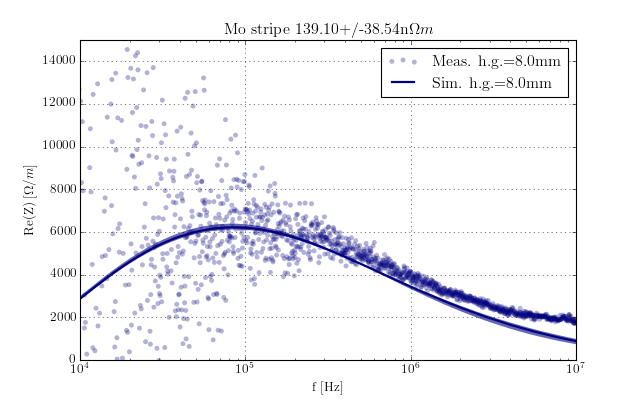

<IPython.core.display.Javascript object>


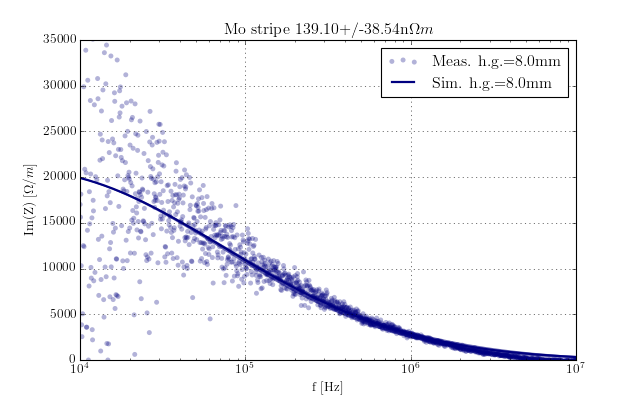

/afs/cern.ch/user/n/nbiancac/ln_work/scratch0/RF/CFC_3coated_sample/Mo_stripe/16-03-2016/thick_probe_N2/Results/reZ_vs_f.pdf
/afs/cern.ch/user/n/nbiancac/ln_work/scratch0/RF/CFC_3coated_sample/Mo_stripe/16-03-2016/thick_probe_N2/Results/imZ_vs_f.pdf


In [80]:
#plot reconstructed
close('all')
rhoDC_vec=np.array([rho_mean,rho_mean+rho_std,rho_mean-rho_std])
lxbatchImp='retrieve'    
h_vec=[];leg_vec=[]; data=[]
cols=[plt.cm.jet(ii) for ii in (np.linspace(0,1,len(hgap_vec)))]
for hgap in hgap_vec:
    
    
    imp_mod={}
    imp_mod['sim']={};imp_mod['meas']={}
    imp_mod['sim']['mat']=[]
    imp_mod['sim']['freq']=[]
    imp_mod['meas']['value']=[]
    imp_mod['meas']['freq']=[]
    
    # IW2D simulations for reference block
    freq=freq_param(fmin=1e4,fmax=1e7,ftypescan=2,nflog=20,fadded=[],fmaxrefine=1e7,fminrefine=1.1e7,nrefine=1)
        
    Alu_lay=Alu_layer(thickness=thick_ref)
    vac_lay=vacuum_layer(thickness=np.inf)
    jaw=construct_layers([Alu_lay,vac_lay])
    comment='_HG'+str(hgap*1e3)+'mm'

    dire=ref_scenario+'/'+str(hgap*1e3)+'/';
    iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
    iw_ref,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
    multiply_impedance_wake(iw_ref,L_active/L_sim)
    
    # IW2D simulations for coated block
    for rhoDC in rhoDC_vec:

        Z_lay=Z_layer(rhoDC=rhoDC, thickness=thick_coat)
        bulk_lay=CFC_layer(thickness=thick_bulk)
        bulk_lay.rhoDC=rhoDC_bulk
        vac_lay=vacuum_layer(thickness=np.inf)
        jaw=construct_layers([Z_lay,bulk_lay,vac_lay])
        comment='_HG'+str(hgap*1e3)+'mm_coat-'+str(thick_coat*1e6)+'um-'+str(rhoDC*1e9)+'nOhmm'
        
        dire=block_scenario+'/'+str(hgap*1e3)+'/';
        iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
        iw_block,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
        multiply_impedance_wake(iw_block,L_active/L_sim)
        if lxbatchImp!='launch':
            a,b,c,d,plane,wakeflag=identify_component('Zydip')
            for iw in iw_block:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_block=iw.func[:,0]+1j*iw.func[:,1]
            for iw in iw_ref:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_ref=iw.func[:,0]+1j*iw.func[:,1]
            imp_mod['sim']['mat'].append(Z_block-Z_ref)
    
    imp_mod['sim']['freq']=freqscan_from_fpar(freq)

    # Measurements
    Block=rf.network.Network((MeasDir+'%dmm/block/TS0.S4P'%(np.round(hgap*1e3))))
    Ref=rf.network.Network((MeasDir+'%dmm/ref/TS0.S4P'%(np.round(hgap*1e3))))

    imp_mod['meas']['value']=clight/(Block.s11.f*2*pi)*(np.squeeze(Block.s11.z)-np.squeeze(Ref.s11.z))/(N**2)/(Delta**2)
    imp_mod['meas']['freq']=Block.s11.f

    newmat=[];
    for kk in np.arange(0,np.size(imp_mod['sim']['mat'],0)):
        col_re=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.real(imp_mod['sim']['mat'][kk]))
        col_im=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.imag(imp_mod['sim']['mat'][kk]))
        col=col_re+1j*col_im;
        newmat.append(col)

    newmat=np.array(newmat)  
    imp_mod['sim']['freq_int']=imp_mod['meas']['freq']
    imp_mod['sim']['mat_int']=newmat
    
    if lxbatchImp=='retrieve':
        figure(4,figsize=(8,5))
        x=imp_mod['sim']['freq_int']
        scatter(imp_mod['meas']['freq'],np.real(imp_mod['meas']['value']),alpha=0.3,edgecolor='none',               
                   color=cols[np.squeeze(np.where(hgap_vec==hgap))],label='Sim. h.g.=%.1fmm'%(hgap*1e3))
        plot(x,np.real(imp_mod['sim']['mat_int'][0,:]),c=cols[np.squeeze(np.where(hgap_vec==hgap))],
                linewidth=2,label='Meas. h.g.=%.1fmm'%(hgap*1e3))
        fill_between(x, np.real(imp_mod['sim']['mat_int'][1,:]), np.real(imp_mod['sim']['mat_int'][2,:]),
                     facecolor=cols[np.squeeze(np.where(hgap_vec==hgap))], alpha=0.6, edgecolor='none')
        xscale('log')
        xlim(10**4,10**7)
        ylim(0,15e3)
        title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f+/-%.2f'%(rho_mean*1e9,rho_std*1e9)+'n\Omega m')
        xlabel('f [Hz]')
        ylabel('Re(Z) [\Omega/m]')

        figure(5,figsize=(8,5))
        x=imp_mod['sim']['freq_int']
        h=scatter(imp_mod['meas']['freq'],np.imag(imp_mod['meas']['value']),alpha=0.3,edgecolor='none',               
                   color=cols[np.squeeze(np.where(hgap_vec==hgap))],label='Meas. h.g.=%.1fmm'%(hgap*1e3))
        h_vec.append(h)
        leg_vec.append('Meas. h.g.=%.1fmm'%(hgap*1e3))
        h,=plot(x,np.imag(imp_mod['sim']['mat_int'][0,:]),c=cols[np.squeeze(np.where(hgap_vec==hgap))],
                linewidth=2,label='Sim. h.g.=%.1fmm'%(hgap*1e3))
        h_vec.append(h)
        leg_vec.append('Sim. h.g.=%.1fmm'%(hgap*1e3))
        fill_between(x, np.imag(imp_mod['sim']['mat_int'][1,:]), np.imag(imp_mod['sim']['mat_int'][2,:]),
                     facecolor=cols[np.squeeze(np.where(hgap_vec==hgap))], alpha=0.6, edgecolor='none')
        xscale('log')
        xlim(10**4,10**7)
        ylim(0,35e3)
        title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f+/-%.2f'%(rho_mean*1e9,rho_std*1e9)+'n\Omega m')
        xlabel('f [Hz]')
        ylabel('Im(Z) [\Omega/m]')
    

if lxbatchImp=='retrieve':
    figure(4)    
    grid()
    legend(h_vec,leg_vec)
    if flagsave:
        print ResultDir+'reZ_vs_f.pdf'
        savefig(ResultDir+'reZ_vs_f.pdf')
        savefig(ResultDir+'reZ_vs_f.png')

    figure(5)    
    grid()
    legend(h_vec,leg_vec)
    if flagsave:
        print ResultDir+'imZ_vs_f.pdf'
        savefig(ResultDir+'imZ_vs_f.pdf')
        savefig(ResultDir+'imZ_vs_f.png')     

## CFC stripe of CFC block 

<IPython.core.display.Javascript object>


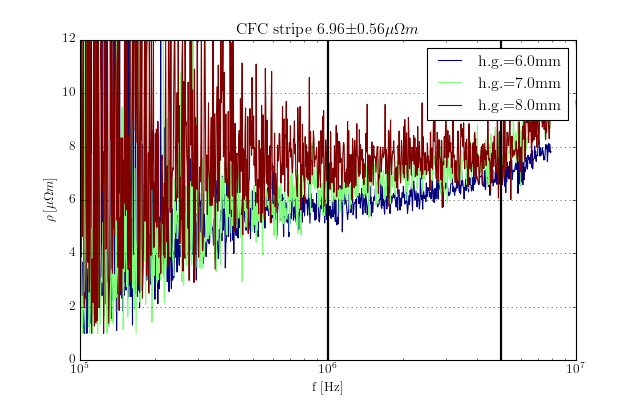

In [53]:
close('all')
IWDir='/afs/cern.ch/user/n/nbiancac/ln_delphi/ImpedanceWake2D/';
block_scenario='CFC_stripe/'
ref_scenario='Al_samples/'

hgap_vec=np.array([6.0,7.0,8.0])*1e-3
rhoDC_vec=np.arange(1,12.5,.5)*1e-6
thick_coat=27e-3
thick_ref=10e-3
L_sim=1
L_active=123e-3; # length of the blocks

# plots
cols=[plt.cm.jet(ii) for ii in (np.linspace(0,1,len(hgap_vec)))]
flagsave=1

# LXPLUS
lxbatchImp='retrieve'
queue='1nh'

# for conductivity determination
flim=[1e6,5e6]; 

#loop
N=2; # num of windings in coil
Delta=6.3e-3; # full distance coil windings

MeasDir='/afs/cern.ch/work/n/nbiancac/scratch0/RF/CFC_3coated_sample/CFC_stripe/16-03-2016/thick_probe_N2/'
ResultDir=MeasDir+'Results/'; 
if not os.path.exists(ResultDir): 
    os.mkdir(ResultDir)
    
h_vec=[];leg_vec=[];rho_mean_vec=[];
fig_=figure(1,figsize=(8,5))
for hgap in hgap_vec:
    
    imp_mod={}
    imp_mod['sim']={};imp_mod['meas']={}
    imp_mod['sim']['mat']=[]
    imp_mod['sim']['freq']=[]
    imp_mod['meas']['value']=[]
    imp_mod['meas']['freq']=[]
    
    # IW2D simulations for reference block
    freq=freq_param(fmin=1e4,fmax=1e7,ftypescan=2,nflog=20,fadded=[],fmaxrefine=1e7,fminrefine=1.1e7,nrefine=1)
        
    Alu_lay=Alu_layer(thickness=thick_ref)
    vac_lay=vacuum_layer(thickness=np.inf)
    jaw=construct_layers([Alu_lay,vac_lay])
    comment='_HG'+str(hgap*1e3)+'mm'

    dire=ref_scenario+'/'+str(hgap*1e3)+'/';
    iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
    iw_ref,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
    multiply_impedance_wake(iw_ref,L_active/L_sim)
    
    # IW2D simulations for coated block
    for rhoDC in rhoDC_vec:

        Z_lay=Z_layer(rhoDC=rhoDC, thickness=thick_coat)
        vac_lay=vacuum_layer(thickness=np.inf)
        jaw=construct_layers([Z_lay,vac_lay])
        comment='_HG'+str(hgap*1e3)+'mm_coat-'+str(thick_coat*1e6)+'um-'+str(rhoDC*1e9)+'nOhmm'
        
        dire=block_scenario+'/'+str(hgap*1e3)+'/';
        iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
        iw_block,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
        multiply_impedance_wake(iw_block,L_active/L_sim)
        if lxbatchImp!='launch':
            a,b,c,d,plane,wakeflag=identify_component('Zydip')
            for iw in iw_block:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_block=iw.func[:,0]+1j*iw.func[:,1]
            for iw in iw_ref:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_ref=iw.func[:,0]+1j*iw.func[:,1]
            imp_mod['sim']['mat'].append(Z_block-Z_ref)

    imp_mod['sim']['freq']=freqscan_from_fpar(freq)

    # Measurements
    Block=rf.network.Network((MeasDir+'%dmm/block/TS0.S4P'%(hgap*1e3)))
    Ref=rf.network.Network((MeasDir+'%dmm/ref/TS0.S4P'%(hgap*1e3)))

    imp_mod['meas']['value']=clight/(Block.s11.f*2*pi)*(np.squeeze(Block.s11.z)-np.squeeze(Ref.s11.z))/(N**2)/(Delta**2)
    imp_mod['meas']['freq']=Block.s11.f

    newmat=[];
    for kk in np.arange(0,np.size(imp_mod['sim']['mat'],0)):
        col=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.real(imp_mod['sim']['mat'][kk]))
        newmat.append(col)

    newmat=np.array(newmat)  
    imp_mod['sim']['freq_int']=imp_mod['meas']['freq']
    imp_mod['sim']['mat_int']=newmat


    if lxbatchImp=='retrieve':
        rho_int=[];
        for kk in np.arange(0,np.size(imp_mod['sim']['mat_int'],1)):
            rho_int.append(np.interp(np.real(imp_mod['meas']['value'][kk]),imp_mod['sim']['mat_int'][:,kk],rhoDC_vec))


        
        h,=semilogx(imp_mod['sim']['freq_int'],np.array(rho_int)*1e6, label='h.g.=%.1fmm'%(hgap*1e3),c=cols[np.squeeze(np.where(hgap_vec==hgap))])
        h_vec.append(h)
        leg_vec.append('h.g.=%.1fmm'%(hgap*1e3))

        rho_vec=np.array(rho_int)
        rho_vec=rho_vec[(imp_mod['sim']['freq_int']>flim[0]) & (imp_mod['sim']['freq_int']<flim[1])]
        rho_mean_vec.append(mean(rho_vec))

rho_mean=mean(rho_mean_vec)
rho_std=std(rho_mean_vec)
axvline(x=flim[0], linewidth=2,color='k')
axvline(x=flim[1], linewidth=2,color='k')
ylim(0, np.max(rhoDC_vec*1e6))
xlim(1e5,1e7)
xlabel(r'\text{f [Hz]}')
ylabel(r'\rho\, [\mu \Omega m]')
legend(tuple(h_vec),tuple(leg_vec))
grid()
title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f\pm%.2f'%(rho_mean*1e6,rho_std*1e6)+'\mu \Omega m')

if flagsave:
    savefig(ResultDir+'rho_vs_f.pdf')
    savefig(ResultDir+'rho_vs_f.png')

<IPython.core.display.Javascript object>


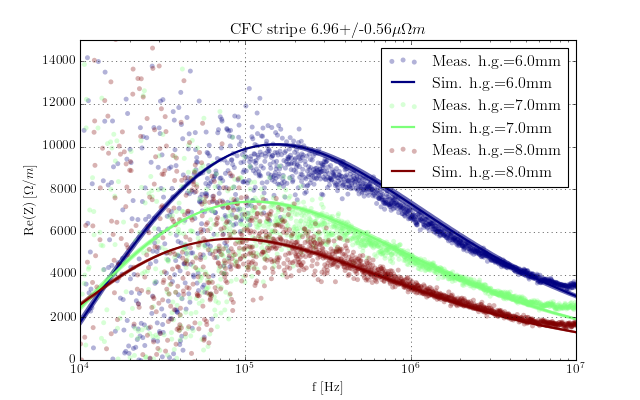

<IPython.core.display.Javascript object>


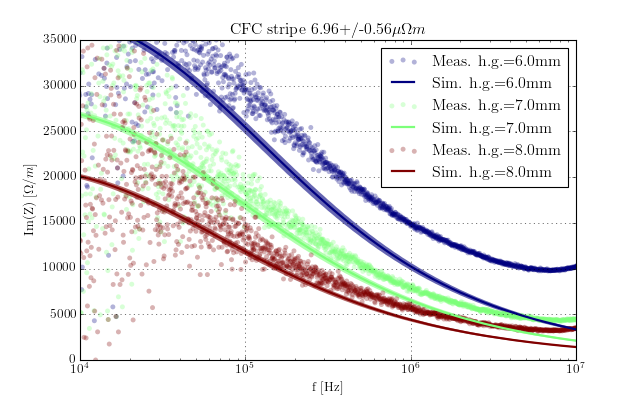

In [56]:
#plot reconstructed
close('all')
rhoDC_vec=np.array([rho_mean,rho_mean+rho_std,rho_mean-rho_std])
lxbatchImp='retrieve'    
h_vec=[];leg_vec=[]; data=[]
cols=[plt.cm.jet(ii) for ii in (np.linspace(0,1,len(hgap_vec)))]
for hgap in hgap_vec:
    
    
    imp_mod={}
    imp_mod['sim']={};imp_mod['meas']={}
    imp_mod['sim']['mat']=[]
    imp_mod['sim']['freq']=[]
    imp_mod['meas']['value']=[]
    imp_mod['meas']['freq']=[]
    
    # IW2D simulations for reference block
    freq=freq_param(fmin=1e4,fmax=1e7,ftypescan=2,nflog=20,fadded=[],fmaxrefine=1e7,fminrefine=1.1e7,nrefine=1)
        
    Alu_lay=Alu_layer(thickness=thick_ref)
    vac_lay=vacuum_layer(thickness=np.inf)
    jaw=construct_layers([Alu_lay,vac_lay])
    comment='_HG'+str(hgap*1e3)+'mm'

    dire=ref_scenario+'/'+str(hgap*1e3)+'/';
    iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
    iw_ref,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
    multiply_impedance_wake(iw_ref,L_active/L_sim)
    
    # IW2D simulations for coated block
    for rhoDC in rhoDC_vec:

        Z_lay=Z_layer(rhoDC=rhoDC, thickness=thick_coat)
        vac_lay=vacuum_layer(thickness=np.inf)
        jaw=construct_layers([Z_lay,vac_lay])
        comment='_HG'+str(hgap*1e3)+'mm_coat-'+str(thick_coat*1e6)+'um-'+str(rhoDC*1e9)+'nOhmm'
        
        dire=block_scenario+'/'+str(hgap*1e3)+'/';
        iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
        iw_block,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
        multiply_impedance_wake(iw_block,L_active/L_sim)
        if lxbatchImp!='launch':
            a,b,c,d,plane,wakeflag=identify_component('Zydip')
            for iw in iw_block:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_block=iw.func[:,0]+1j*iw.func[:,1]
            for iw in iw_ref:
                if test_impedance_wake_comp(iw, a, b, c, d, plane):
                    Z_ref=iw.func[:,0]+1j*iw.func[:,1]
            imp_mod['sim']['mat'].append(Z_block-Z_ref)
    
    imp_mod['sim']['freq']=freqscan_from_fpar(freq)

    # Measurements
    Block=rf.network.Network((MeasDir+'%dmm/block/TS0.S4P'%(hgap*1e3)))
    Ref=rf.network.Network((MeasDir+'%dmm/ref/TS0.S4P'%(hgap*1e3)))

    imp_mod['meas']['value']=clight/(Block.s11.f*2*pi)*(np.squeeze(Block.s11.z)-np.squeeze(Ref.s11.z))/(N**2)/(Delta**2)
    imp_mod['meas']['freq']=Block.s11.f

    newmat=[];
    for kk in np.arange(0,np.size(imp_mod['sim']['mat'],0)):
        col_re=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.real(imp_mod['sim']['mat'][kk]))
        col_im=np.interp(imp_mod['meas']['freq'],imp_mod['sim']['freq'],np.imag(imp_mod['sim']['mat'][kk]))
        col=col_re+1j*col_im;
        newmat.append(col)

    newmat=np.array(newmat)  
    imp_mod['sim']['freq_int']=imp_mod['meas']['freq']
    imp_mod['sim']['mat_int']=newmat
    
    if lxbatchImp=='retrieve':
        figure(4,figsize=(8,5))
        x=imp_mod['sim']['freq_int']
        scatter(imp_mod['meas']['freq'],np.real(imp_mod['meas']['value']),alpha=0.3,edgecolor='none',               
                   color=cols[np.squeeze(np.where(hgap_vec==hgap))],label='Sim. h.g.=%.1fmm'%(hgap*1e3))
        plot(x,np.real(imp_mod['sim']['mat_int'][0,:]),c=cols[np.squeeze(np.where(hgap_vec==hgap))],
                linewidth=2,label='Meas. h.g.=%.1fmm'%(hgap*1e3))
        fill_between(x, np.real(imp_mod['sim']['mat_int'][1,:]), np.real(imp_mod['sim']['mat_int'][2,:]),
                     facecolor=cols[np.squeeze(np.where(hgap_vec==hgap))], alpha=0.6, edgecolor='none')
        xscale('log')
        xlim(10**4,10**7)
        ylim(0,15e3)
        title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f+/-%.2f'%(rho_mean*1e6,rho_std*1e6)+'\mu\Omega m')
        xlabel('f [Hz]')
        ylabel('Re(Z) [\Omega/m]')

        figure(5,figsize=(8,5))
        x=imp_mod['sim']['freq_int']
        h=scatter(imp_mod['meas']['freq'],np.imag(imp_mod['meas']['value']),alpha=0.3,edgecolor='none',               
                   color=cols[np.squeeze(np.where(hgap_vec==hgap))],label='Meas. h.g.=%.1fmm'%(hgap*1e3))
        h_vec.append(h)
        leg_vec.append('Meas. h.g.=%.1fmm'%(hgap*1e3))
        h,=plot(x,np.imag(imp_mod['sim']['mat_int'][0,:]),c=cols[np.squeeze(np.where(hgap_vec==hgap))],
                linewidth=2,label='Sim. h.g.=%.1fmm'%(hgap*1e3))
        h_vec.append(h)
        leg_vec.append('Sim. h.g.=%.1fmm'%(hgap*1e3))
        fill_between(x, np.imag(imp_mod['sim']['mat_int'][1,:]), np.imag(imp_mod['sim']['mat_int'][2,:]),
                     facecolor=cols[np.squeeze(np.where(hgap_vec==hgap))], alpha=0.6, edgecolor='none')
        xscale('log')
        xlim(10**4,10**7)
        ylim(0,35e3)
        title(block_scenario.replace('_',' ').replace('/','')+' '+'%.2f+/-%.2f'%(rho_mean*1e6,rho_std*1e6)+'\mu\Omega m')
        xlabel('f [Hz]')
        ylabel('Im(Z) [\Omega/m]')
    


figure(4)    
grid()
legend(h_vec,leg_vec)
if flagsave:
    savefig(ResultDir+'reZ_vs_f.pdf')
    savefig(ResultDir+'reZ_vs_f.png')
    
figure(5)    
grid()
legend(h_vec,leg_vec)
if flagsave:
    savefig(ResultDir+'imZ_vs_f.pdf')
    savefig(ResultDir+'imZ_vs_f.png')
    
        

# Flipping a block 

## Mo on CFC


In [ ]:
IWDir='/afs/cern.ch/user/n/nbiancac/ln_delphi/ImpedanceWake2D/';
folder='Mo_on_CFC_flipped/';

hgap=8.0*1e-3
thick_coat=7e-6;
Mo_lay=Mo_layer(thickness=thick_coat)
CFC_lay=CFC_layer(thickness=27e-3)
vac_lay=vacuum_layer(thickness=np.inf)
freq=freq_param(fmin=1e4,fmax=1e7,ftypescan=2,nflog=20,fadded=[],fmaxrefine=1e7,fminrefine=1e7,nrefine=0)

scenario={};
scenario['position']=['bulk','bulk-coat'];
scenario['jaw']=[construct_layers([CFC_lay,vac_lay]),construct_layers([CFC_lay,Mo_lay,vac_lay])]
ind=np.arange(0,len((scenario['jaw'])))

lxplusImp='retrieve';
imp_mod=[];
for ii in ind:
    jaw=scenario['jaw'][ii]

    comment='_HG'+str(hgap*1e3)+'mm_coat-'+str(thick_coat*1e6)+'um_'+scenario['position'][ii]
    dire=folder+'/'+str(hgap*1e3)+'/';
    queue='1nh'
    print comment 

    iw_input=impedance_wake_input(machine='LHC',b=[hgap,0],layers=jaw,fpar=freq,geometry='flat',comment=comment)
    iw=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxplusImp,queue=queue,dire=dire);
    imp_mod.append(iw)

if lxplusImp=='retrieve':
    iw=imp_mod[0][0][2]
    test_impedance_wake_comp?
    print iw.plane, iw.a, iw.b
    test_impedance_wake_comp(iw,1,0,0,0,'x')
    Z=deepcopy(iw.func[::1,:]);freq=deepcopy(iw.var[::1]);
    plot(freq,(Z[:,1]))

    iw=imp_mod[1][0][2]
    test_impedance_wake_comp?
    print iw.plane, iw.a, iw.b
    test_impedance_wake_comp(iw,1,0,0,0,'x')
    Z=deepcopy(iw.func[::1,:]);freq=deepcopy(iw.var[::1]);
    plot(freq,(Z[:,1]))

    legend(scenario['position'])


#  Conductivity scan

In [172]:
close('all')
IWDir='/afs/cern.ch/user/n/nbiancac/ln_delphi/ImpedanceWake2D/';
block_scenario='CuTiC_TDI/'

hgap=np.array([3.8])*1e-3
rhoDC_vec=np.arange(30,40,5)*1e-9
thick_cu=2e-6
thick_ti=.1e-6
thick_C=54e-3
L=2.8


# plots
flagsave=0

# LXPLUS
lxbatchImp='retrieve'
queue='1nh'

imp_mod=[];
for rhoDC in rhoDC_vec:
    
    # IW2D simulations for reference block
    freq=freq_param(fmin=1e3,fmax=2e9,ftypescan=2,nflog=20,fadded=[],fmaxrefine=1e7,fminrefine=1.1e7,nrefine=1)
        
    Cu_lay=layer(rhoDC=rhoDC,tau=0.027e-12/(2.6/1.7),epsb=1,mur=1,fmu=np.inf,thickness=thick_cu);
    Ti_lay=Ti_layer(thickness=thick_ti)
    C_lay=graphite_layer(thickness=thick_C)
    vac_lay=vacuum_layer(thickness=np.inf)
    jaw=construct_layers([Cu_lay,Ti_lay,C_lay,vac_lay])
    comment='_HG%.1fmm_rhoDC%.1f'%(hgap*1e3,rhoDC*1e9)

    dire=block_scenario+'/%.1f/'%(hgap*1e3);
    iw_input=impedance_wake_input(machine='LHC',b=[hgap],layers=jaw,fpar=freq,geometry='flat',comment=comment)
    iw_block,[]=imp_model_from_IW2D(iw_input,wake_calc=False,path=IWDir,flagrm=True, lxplusbatch=lxbatchImp,queue=queue,dire=dire);
    
    beta_av=71.;
    beta_tdi=46.;
    multiply_impedance_wake(iw_block,L*beta_tdi/beta_av)
    if lxbatchImp!='launch':
        imp_mod.append(iw_block)

    freqscan=freqscan_from_fpar(freq)
        
        
if flagsave:
    savefig(ResultDir+'Z_vs_rho.pdf')
    savefig(ResultDir+'Z_vs_rho.png')

## Tune shift from TDI RW model

In [ ]:
pyDir='/afs/cern.ch/user/n/nbiancac/ln_work/scratch0/IRIS/PYTHON_codes_and_scripts/LHC_impedance_and_scripts/'
sys.path.append(pyDir)

from LHC_param import *
from particle_param import *

In [109]:
e,m0,c,E0=proton_param();
machine=LHC(E0,E=450e9,scenario='Nominal LHC')

mmax=0
Qpscan=np.array([0]);
nxscan=np.array([0])
Nbscan=np.array([1.2e11])
omegasscan=np.array([0])
M=1;
machine.taub=1.2e-9
ts=sacherer(imp_mod[0], Qpscan, nxscan, Nbscan, omegasscan, M, machine.omega0, machine.Qy, machine.gamma, machine.eta,
         machine.taub, mmax, particle='proton', modetype='sinusoidal', compname='Zydip')
tsd=-real(np.ravel(ts[0]))
ts=sacherer(imp_mod[0], Qpscan, nxscan, Nbscan, omegasscan, M, machine.omega0, machine.Qy, machine.gamma, machine.eta,
         machine.taub, mmax, particle='proton', modetype='sinusoidal', compname='Zyquad')
tsq=-real(np.ravel(ts[0]))
print tsd+tsq

Sacherer: Qp= 0 , M= 1 , omegas= 0 , m= 0 , Most unstable coupled-bunch mode:  0
Sacherer: Qp= 0 , M= 1 , omegas= 0 , m= 0 , Most unstable coupled-bunch mode:  0
[  5.31376927e-06]


## Tune shift from CST TDI model

<IPython.core.display.Javascript object>


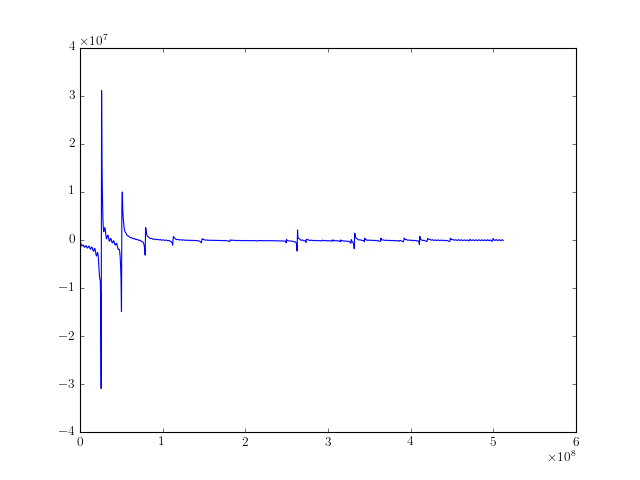

Sacherer: Qp= 0 , M= 1 , omegas= 0 , m= 0 , Most unstable coupled-bunch mode:  0


In [202]:
fileCST=np.genfromtxt('/afs/cern.ch/user/n/nbiancac/ln_work/scratch0/IRIS/CST/TDI2016/TDIhg2mm_dispy1mm.txt',
                    dtype=float,skip_header=2)
freq=fileCST[:,0]*1e9;
Zre=np.array(0*fileCST[:,1]/1e-3)
Zim=np.array(fileCST[:,1]/1e-3)
Z=np.column_stack([Zre,Zim])
iw_CST=[impedance_wake(a=0,b=1,c=0,d=0,plane='y',var=freq,func=Z)]

multiply_impedance_wake(iw_CST,beta_tdi/beta_av)

figure(1)
plot(freq,real(Z[:,1]))
ts=sacherer(iw_CST, Qpscan, nxscan, Nbscan, omegasscan, M, machine.omega0, machine.Qy, machine.gamma, machine.eta,
         machine.taub, mmax, particle='proton', modetype='sinusoidal', compname='Zydip')
tsd_CST=-real(np.ravel(ts[0]))




In [201]:
tsd_CST


array([ -1.27245727e-05])